In [1]:
!pip install causalml

In [2]:
!pip install scikit-uplift

In [3]:
!pip install duecredit

In [4]:
# 1. 라이브러리 임포트
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.meta import BaseDRLearner
from causalml.metrics import plot_qini, qini_score, auuc_score
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

데이터 불러오기

In [5]:

import pandas as pd

df = pd.read_csv("hf://datasets/criteo/criteo-uplift/criteo-research-uplift-v2.1.csv.gz")

In [6]:
df

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13979587,26.297764,10.059654,9.006250,4.679882,10.280525,4.115453,-3.282109,4.833815,3.839578,13.190056,5.300375,-0.168679,1,0,0,0
13979588,12.642207,10.679513,8.214383,-1.700105,10.280525,3.013064,-13.955150,6.269026,3.971858,13.190056,5.300375,-0.168679,1,0,0,1
13979589,12.976557,10.059654,8.381868,0.842442,11.029584,4.115453,-8.281971,4.833815,3.779212,23.570168,6.169187,-0.168679,1,0,1,0
13979590,24.805064,10.059654,8.214383,4.679882,10.280525,4.115453,-1.288207,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


### 데이터 전처리

In [7]:
df_sampled = df.sample(n=100_000, random_state=42)  # 약 0.7% 수준


In [8]:
df_sampled['treatment_group_key']=df_sampled["treatment"].apply(lambda x: "treatment" if x==1 else "control")

데이터 EDA

#### 처치 변수와 결과변수 사이 상관관계 분석

In [9]:
df_corr = df_sampled[[f"f{i}" for i in range(12)] + ["treatment","conversion","visit","exposure"]].corr()

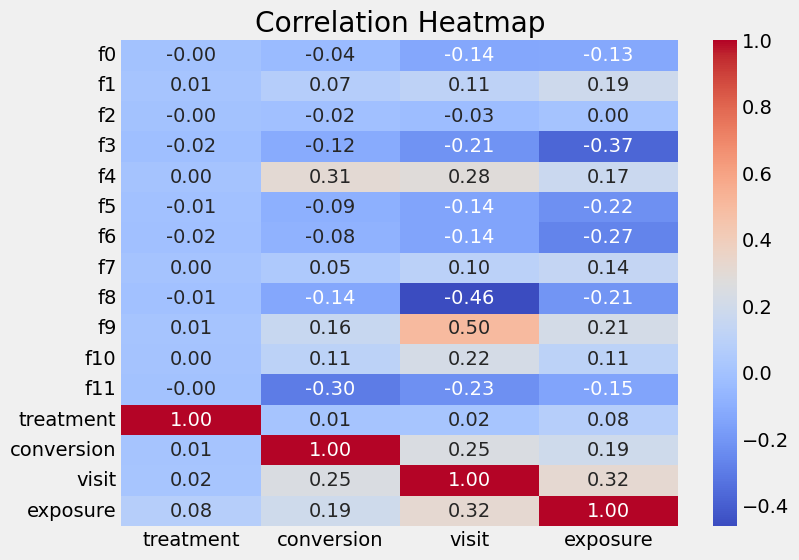

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr[["treatment","conversion","visit","exposure"]], annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

초기에는 exposure(광고 노출) 변수를 처치 변수로 고려하였으나, 노출 여부가 개인의 행동 특성(예: 광고 차단기 사용, 낮은 관심도, 웹사이트내 짧은 체류 시간 등)에 따라 결정될 수 있어 자기 선택적 노출(self-selection bias) 문제가 존재한다고 판단하였다. 이로 인해 내생성(endogeneity) 우려가 있어, 인과적 해석을 전제로 하는 처치 변수로 사용하기에는 적절하지 않다고 보았다.

또한 상관관계 히트맵(Figure 1)을 통해 살펴본 결과,

treatment 변수는 대부분의 변수와 상관관계가 거의 0에 수렴하여, 실험적 처치처럼 독립적으로 부여된 특성을 보이는 반면,

exposure 변수는 결과 변수인 visit (0.31), conversion (0.17)을 포함하여 다양한 변수들과 유의미한 상관관계를 보인다.

이는 exposure가 단순한 처치에 의해 할당된 결과라기 보단, 오히려 여러 변수와 구조적으로 연결된 설명 변수(feature)로서의 성격이 강함을 시사한다.
따라서 본 분석에서는 exposure를 처치가 아닌 feature로 포함하여, 예측 성능 향상에 기여하는 설명 변수로 활용하였다.

In [11]:
pd.crosstab(
    [df_sampled['treatment_group_key'], df_sampled['exposure']],
    [df_sampled['visit'], df_sampled['conversion']],
    margins=True,
    normalize=True
)


visit                               0        1               All
conversion                          0        0        1         
treatment_group_key exposure                                    
control             0         0.14376  0.00561  0.00026  0.14963
treatment           0         0.79065  0.02742  0.00086  0.81893
                    1         0.01807  0.01140  0.00197  0.03144
All                           0.95248  0.04443  0.00309  1.00000

1. 통제 그룹에서는 광고에 노출된 경우가 없음
2. 처치 그룹에서 노출될 경우 전환할 확률이 그렇지 않은 경우에 비해 2배정도 높음
3. 그러나 광고 노출 이후에 사이트에 방문하여도 전환 비율은 그렇지 않은 경우에 비해 현저히 낮음

In [12]:
# 이상 케이스: 방문하지 않았지만 전환한 경우
abnormal_case = df_sampled[(df_sampled['visit'] == 0) & (df_sampled['conversion'] == 1)]

print(f"이상 케이스 수: {len(abnormal_case)}")
print(abnormal_case.head())


이상 케이스 수: 0
Empty DataFrame
Columns: [f0, f1, f2, f3, f4, f5, f6, f7, f8, f9, f10, f11, treatment, conversion, visit, exposure, treatment_group_key]
Index: []


모든 전환 즉, 구매는 사이트에 방문하여야지만 가능한 구조임


In [13]:
df_sampled["conversion"][df_sampled["treatment"]==1].mean()-df_sampled["conversion"][df_sampled["treatment"]==0].mean()
# 랜덤 기대 uplift가 거의 0

np.float64(0.0015903436605971906)

 랜덤 기대 uplift가 거의 0임 -> 본 데이터 셋이 무작위 할당 실험에 부합함

#### 타겟 설정

In [14]:

df_sampled['treatment'] = (df_sampled['treatment_group_key'] == 'treatment').astype(int)


X = df_sampled[[f'f{i}' for i in range(12)] +["exposure"]] # 예: f0~f11까지 feature

treatment =df_sampled['treatment_group_key']
y=df_sampled["conversion"]

방문과 전환을 동시에 고려하는 변수를 만들어보았으나 불균형이 심함 ->
아래 변수는 사용하지 않는 것으로 결정

In [15]:
y_composition=df_sampled['visit'] *df_sampled['conversion']

In [16]:
y_composition.value_counts()

,count
0,99691
1,309


위 데이터 eda과정에서 전환은 사이트 방문 이후에만 가능한 것을 확인했다. 따라서 방문 urift효과와 방문 후 전환 uprift효과를 나누어 보도록 한다.

In [17]:

X_visit = df_sampled[[f'f{i}' for i in range(12)] +["exposure"]] # 예: f0~f11까지 feature

treatment_visit =df_sampled['treatment_group_key']
y_visit = df_sampled['visit']   # 방문 여부 (0/1)


X_visit = df_sampled[[f'f{i}' for i in range(12)] +["exposure"]] # 예: f0~f11까지 feature

treatment_conversion =df_sampled['treatment_group_key'][df_sampled["visit"]==1]
X_conversion = df_sampled[[f'f{i}' for i in range(12)] +["exposure"]][df_sampled["visit"]==1] # 방문 여부 (0/1)
y_conversion = df_sampled['conversion'][df_sampled["visit"]==1]  # 방문 후 구매 여부 (0/1)

In [18]:
y_visit.value_counts()

,count
visit,
0,95248
1,4752


In [19]:
y_conversion.value_counts()

,count
conversion,
0,4443
1,309


In [20]:
y_conversion[X_conversion["exposure"]==1].value_counts()

,count
conversion,
0,1140
1,197


#### 최적 파라메터 정의

##### 최적 파라메터 찾는 함수 정의

In [21]:
from sklearn.model_selection import KFold
from sklift.metrics import uplift_auc_score
from causalml.inference.tree import UpliftTreeClassifier
import numpy as np
import pandas as pd

def run_uplift_tree_cv(X, y, treatment, control_name='control',
                       max_depth_list=[3, 4, 5],
                       min_samples_leaf_list=[100, 500, 1000, 2000, 3000],
                       n_splits=5, random_state=42):
    """
    UpliftTreeClassifier를 이용한 K-Fold 교차검증 수행 및 최적 하이퍼파라미터 탐색.

    Parameters:
        X (pd.DataFrame): Feature 데이터
        y (pd.Series): 타겟 (예: visit 또는 conversion)
        treatment (pd.Series): 처치 그룹 (control/treatment 등)
        control_name (str): 대조군 이름
        max_depth_list (list): max_depth 후보 리스트
        min_samples_leaf_list (list): min_samples_leaf 후보 리스트
        n_splits (int): KFold 분할 수
        random_state (int): 재현성 위한 랜덤시드

    Returns:
        best_params (dict): 최적 하이퍼파라미터 조합
        best_score (float): 최고 uplift AUC score
    """

    param_grid = {
        'max_depth': max_depth_list,
        'min_samples_leaf': min_samples_leaf_list
    }

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    best_params = None
    best_score = -np.inf

    for max_depth in param_grid['max_depth']:
        for min_samples_leaf in param_grid['min_samples_leaf']:
            scores = []

            for train_idx, test_idx in kf.split(X):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                t_train, t_test = treatment.iloc[train_idx], treatment.iloc[test_idx]

                model = UpliftTreeClassifier(
                    control_name=control_name,
                    max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf
                )

                model.fit(X_train, treatment=t_train.values, y=y_train.values)
                uplift_preds = model.predict(X_test)
                uplift_scores = uplift_preds[:, 1] - uplift_preds[:, 0]

                # Binary 처리
                t_test_bin = t_test.map({control_name: 0, 'treatment': 1})
                y_test_bin = (y_test > 0).astype(int)

                score = uplift_auc_score(y_test_bin, uplift_scores, t_test_bin)
                scores.append(score)

            avg_score = np.mean(scores)
            print(f"max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf} -> 평균 Uplift Score: {avg_score:.4f}")

            if avg_score > best_score:
                best_score = avg_score
                best_params = {'max_depth': max_depth, 'min_samples_leaf': min_samples_leaf}

    print("\n" + "="*50)
    print(f"최적의 하이퍼파라미터: {best_params}")
    print(f"최고 평균 Uplift Score: {best_score:.4f}")
    print("="*50)

    return best_params, best_score


In [22]:
from causalml.inference.tree import UpliftRandomForestClassifier
from sklearn.model_selection import KFold
from sklift.metrics import uplift_auc_score
import numpy as np
import pandas as pd

def run_uplift_rf_cv(X, y, treatment, control_name='control',
                     n_estimators=30,
                     max_depth_list=[3, 4, 5],
                     min_samples_leaf_list = [ 100, 500, 1000, 2000, 3000],
                     n_splits=5, random_state=42):
    """
    UpliftRandomForestClassifier를 이용한 K-Fold 교차검증 및 최적 하이퍼파라미터 탐색.

    Parameters:
        X (pd.DataFrame): Feature 데이터
        y (pd.Series): 타겟 (예: visit 또는 conversion)
        treatment (pd.Series): 처치 그룹 (control/treatment 등)
        control_name (str): 대조군 이름
        n_estimators (int): 랜덤포레스트의 트리 개수
        max_depth_list (list): max_depth 후보 리스트
        min_samples_leaf_list (list): min_samples_leaf 후보 리스트
        n_splits (int): KFold 분할 수
        random_state (int): 랜덤시드

    Returns:
        best_params (dict): 최적의 하이퍼파라미터 조합
        best_score (float): 최고 uplift AUC score
    """

    param_grid = {
        'max_depth': max_depth_list,
        'min_samples_leaf': min_samples_leaf_list
    }

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    best_params = None
    best_score = -np.inf

    for max_depth in param_grid['max_depth']:
        for min_samples_leaf in param_grid['min_samples_leaf']:
            scores = []

            for train_idx, test_idx in kf.split(X):
                X_train = X.iloc[train_idx].reset_index(drop=True)
                X_test = X.iloc[test_idx].reset_index(drop=True)
                y_train = y.iloc[train_idx].reset_index(drop=True)
                y_test = y.iloc[test_idx].reset_index(drop=True)
                t_train = treatment.iloc[train_idx].reset_index(drop=True)
                t_test = treatment.iloc[test_idx].reset_index(drop=True)

                model = UpliftRandomForestClassifier(
                    control_name=control_name,
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf,
                    random_state=random_state
                )

                model.fit(X_train.values, treatment=t_train.values, y=y_train.values)
                uplift_preds = model.predict(X_test)


                t_test_bin = t_test.map({control_name: 0, 'treatment': 1})
                y_test_bin = (y_test > 0).astype(int)

                score = uplift_auc_score(y_test_bin, uplift_preds, t_test_bin)
                scores.append(score)

            avg_score = np.mean(scores)
            print(f"max_depth: {max_depth}, min_samples_leaf: {min_samples_leaf} -> 평균 Uplift Score: {avg_score:.4f}")

            if avg_score > best_score:
                best_score = avg_score
                best_params = {
                    'max_depth': max_depth,
                    'min_samples_leaf': min_samples_leaf,
                    'n_estimators': n_estimators
                }

    print("\n" + "=" * 50)
    print(f"최적의 하이퍼파라미터: {best_params}")
    print(f"최고 평균 Uplift Score: {best_score:.4f}")
    print("=" * 50)

    return best_params, best_score


##### 최적 파라메터 찾기

uprift tree visit

In [ ]:
run_uplift_tree_cv(X,y_visit,treatment)

uprift tree visit 후 conversion

In [ ]:
run_uplift_tree_cv(X_conversion,y_conversion,treatment_conversion)

uprift randomforest visit

데이터 불균형이 심해 SMOTENC을 사용해 upsampling을 진행한다.

In [23]:
!pip install -U imbalanced-learn


In [24]:

from imblearn.over_sampling import SMOTENC

In [25]:

treatment = df_sampled['treatment_group_key']

# X와 treatment를 하나의 데이터프레임으로 합참
# y_resampling 변수는 SMOTENC의 y 입력값으로 사용
X_resampling = pd.concat([X_visit, treatment_visit], axis=1)
y_resampling = y_visit


cat_idx = [X_resampling.columns.get_loc("exposure"), X_resampling.columns.get_loc("treatment_group_key")]

# SMOTENC를 사용하여 X_resampling과 y_resampling을 리샘플링
smotenc = SMOTENC(categorical_features=cat_idx, random_state=42)
X_res_all, y_res = smotenc.fit_resample(X_resampling, y_resampling)

# 리샘플링된 데이터셋(X_res_all)을 다시 X와 treatment로 분리
X_res = X_res_all.drop(columns='treatment_group_key')
treatment_res = X_res_all['treatment_group_key']



In [26]:
y_res.value_counts()

,count
visit,
0,95248
1,95248


In [27]:
X_res = X_res.sample(n=100_000, random_state=42)
y_res = y_res.sample(n=100_000, random_state=42)
treatment_res = treatment_res.sample(n=100_000, random_state=42)

In [28]:
run_uplift_rf_cv(X_res,y_res,treatment_res)

max_depth: 3, min_samples_leaf: 100 -> 평균 Uplift Score: 0.2035
max_depth: 3, min_samples_leaf: 500 -> 평균 Uplift Score: 0.2035
max_depth: 3, min_samples_leaf: 1000 -> 평균 Uplift Score: 0.2035
max_depth: 3, min_samples_leaf: 2000 -> 평균 Uplift Score: 0.2035
max_depth: 3, min_samples_leaf: 3000 -> 평균 Uplift Score: 0.2035
max_depth: 4, min_samples_leaf: 100 -> 평균 Uplift Score: 0.2035
max_depth: 4, min_samples_leaf: 500 -> 평균 Uplift Score: 0.2035
max_depth: 4, min_samples_leaf: 1000 -> 평균 Uplift Score: 0.2035
max_depth: 4, min_samples_leaf: 2000 -> 평균 Uplift Score: 0.2035
max_depth: 4, min_samples_leaf: 3000 -> 평균 Uplift Score: 0.2035
max_depth: 5, min_samples_leaf: 100 -> 평균 Uplift Score: 0.2035
max_depth: 5, min_samples_leaf: 500 -> 평균 Uplift Score: 0.2035
max_depth: 5, min_samples_leaf: 1000 -> 평균 Uplift Score: 0.2035
max_depth: 5, min_samples_leaf: 2000 -> 평균 Uplift Score: 0.2035
max_depth: 5, min_samples_leaf: 3000 -> 평균 Uplift Score: 0.2035

최적의 하이퍼파라미터: {'max_depth': 3, 'min_samples_le

({'max_depth': 3, 'min_samples_leaf': 100, 'n_estimators': 30},
 np.float64(0.20351550141987818))

In [29]:

treatment = df_sampled['treatment_group_key']

# X와 treatment를 하나의 데이터프레임으로 합참
# y_resampling 변수는 SMOTENC의 y 입력값으로 사용
X_resampling = pd.concat([X_conversion, treatment_conversion], axis=1)
y_resampling = y_conversion


cat_idx = [X_resampling.columns.get_loc("exposure"), X_resampling.columns.get_loc("treatment_group_key")]

# SMOTENC를 사용하여 X_resampling과 y_resampling을 리샘플링
smotenc = SMOTENC(categorical_features=cat_idx, random_state=42)
X_res_all, y_res = smotenc.fit_resample(X_resampling, y_resampling)

# 리샘플링된 데이터셋(X_res_all)을 다시 X와 treatment로 분리
X_res = X_res_all.drop(columns='treatment_group_key')
treatment_res = X_res_all['treatment_group_key']



In [ ]:
run_uplift_rf_cv(X_res,y_res,treatment_res)

데이터 분할

In [30]:

# 1. visit용 split
X_train_v, X_test_v, y_train_v, y_test_v, t_train_v, t_test_v = train_test_split(
    X, y_visit, treatment, test_size=0.2, random_state=42
)

# 2. visit 후 conversion용 split
X_train_c, X_test_c, y_train_c, y_test_c, t_train_c, t_test_c = train_test_split(
    X_conversion, y_conversion,
treatment_conversion , test_size=0.2, random_state=42
)
# 3. 전체 데이터용 데이터 split
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(
    X, y, treatment, test_size=0.2, random_state=42
)
# 🔹 visit용 split (index 통일 및 형식 변환)
X_train_v = pd.DataFrame(X_train_v, columns=X.columns).reset_index(drop=True)
X_test_v = pd.DataFrame(X_test_v, columns=X.columns).reset_index(drop=True)

y_train_v = pd.Series(y_train_v).reset_index(drop=True)
y_test_v = pd.Series(y_test_v).reset_index(drop=True)

t_train_v = pd.Series(t_train_v).reset_index(drop=True)
t_test_v = pd.Series(t_test_v).reset_index(drop=True)

# 🔹 visit 후 conversion용 split (index 통일 및 형식 변환)
X_train_c = pd.DataFrame(X_train_c, columns=X.columns).reset_index(drop=True)
X_test_c = pd.DataFrame(X_test_c, columns=X.columns).reset_index(drop=True)

y_train_c = pd.Series(y_train_c).reset_index(drop=True)
y_test_c = pd.Series(y_test_c).reset_index(drop=True)

t_train_c = pd.Series(t_train_c).reset_index(drop=True)
t_test_c = pd.Series(t_test_c).reset_index(drop=True)

# 전체 데이터용 slit(index 통일 및 형식 변환)
X_train = pd.DataFrame(X_train, columns=X.columns).reset_index(drop=True)
X_test = pd.DataFrame(X_test, columns=X.columns).reset_index(drop=True)

y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)

t_train = pd.Series(t_train).reset_index(drop=True)
t_test = pd.Series(t_test).reset_index(drop=True)

최적 파라메터를 사용한 모델 학습

single model 학습
  - uplift tree
  - uplift randomfrest

In [31]:
# 4. 모델 학습
## (1) 단일 업리프트 트리
tree_v = UpliftTreeClassifier(control_name='control', max_depth=5,
    min_samples_leaf=3000)
tree_v.fit(X_train_v, treatment=t_train_v, y=y_train_v)

tree_c = UpliftTreeClassifier(control_name='control', max_depth=3,
    min_samples_leaf=1000)
tree_c.fit(X_train_c, treatment=t_train_c, y=y_train_c)

In [32]:
from sklift.metrics import uplift_auc_score

In [33]:
## (2) 업리프트 랜덤포레스트
forest_v = UpliftRandomForestClassifier(control_name='control',max_depth=3, n_estimators=30,min_samples_leaf=100)
forest_v.fit(X_train_v.values, treatment=t_train_v.values, y=y_train_v.values)

forest_c = UpliftRandomForestClassifier(control_name='control',max_depth=3, n_estimators=30,min_samples_leaf=100)
forest_c.fit(X_train_c.values, treatment=t_train_c.values, y=y_train_c.values)

#### 결과 비교

In [34]:
x_names=[f'f{i}' for i in range(12)] +["exposure"]

train

In [35]:
from IPython.display import Image

uplift tree visit 결과

uplift tree  train 결과
----------------------------------------------------------------------------------------------------
f3 >= 0.9738407885786832?
yes -> f6 >= -12.110436001190244?
		yes -> f9 >= 31.477539575896326?
				yes -> [np.float64(0.3388888888888889), np.float64(0.37163892445582586)]
				no  -> f9 >= 22.57032907395953?
						yes -> [np.float64(0.15422885572139303), np.float64(0.16437938395852394)]
						no  -> [np.float64(0.010866253681324262), np.float64(0.010084278355206873)]
		no  -> [np.float64(0.06495726495726496), np.float64(0.10615577889447236)]
no  -> [np.float64(0.11187214611872145), np.float64(0.21311002021368755)]


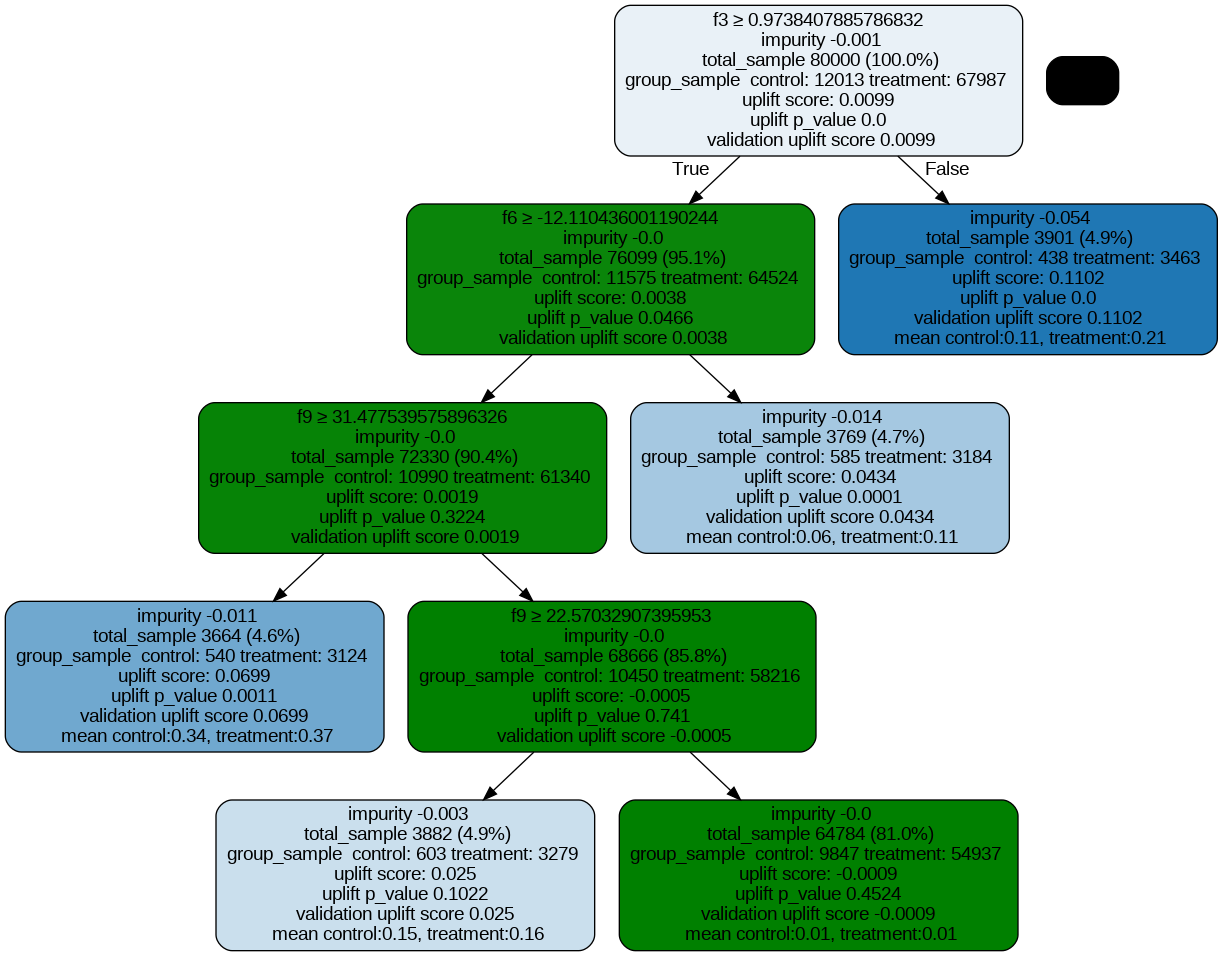

In [36]:
# Print uplift tree as a string
print("uplift tree  train 결과")
print("-"*100)
result_tree = uplift_tree_string(tree_v.fitted_uplift_tree, x_names)
# Plot uplift tree
graph = uplift_tree_plot(tree_v.fitted_uplift_tree,x_names)
Image(graph.create_png())



1. `f3 < 0.9738` 그룹은 전체의 4.9%를 차지하며, uplift score가 0.1102로 가장 크다.
2. `f3 ≥ 0.9738` 이고 `f6 ≥ –12.11` 이며 `f9 < 31.48` 그룹은 전체의 약 4.6%를 차지하며, uplift score가 0.0699로 두번째로 크다.
3. `f3 ≥ 0.9738` 이고 `f6 < –12.11` 그룹은 전체의 약 5.3%를 차지하며, uplift score가 0.04524로 세번째로 크다



uplift tree visit 후 conversion 결과

uplift tree  train 결과
----------------------------------------------------------------------------------------------------
f6 >= -11.198568534799534?
yes -> f6 >= 0.294442711255606?
		yes -> [np.float64(0.03821656050955414), np.float64(0.0205761316872428)]
		no  -> [np.float64(0.048672566371681415), np.float64(0.04954268292682927)]
no  -> [np.float64(0.07692307692307693), np.float64(0.12080536912751678)]


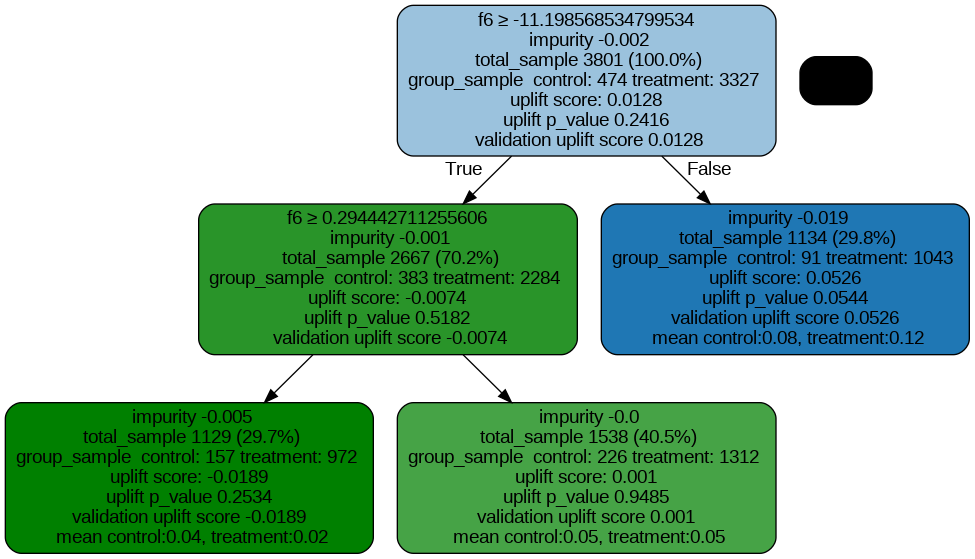

In [37]:
# Print uplift tree as a string
print("uplift tree  train 결과")
print("-"*100)
result_tree = uplift_tree_string(tree_c.fitted_uplift_tree, x_names)
# Plot uplift tree
graph = uplift_tree_plot(tree_c.fitted_uplift_tree,x_names)
Image(graph.create_png())


전반적으로 p-value 값이 커서 크게 유의미한 결과를 얻었다고 하기 어렵다. 그나마 고르자면 f6 <-11.20이 가장 유의미한 집단이다 . uplift score도 0.0526으로 가장 크다.

uplift randomforest visit 결과

----------------------------------------------------------------------------------------------------
uplift random forest  train 결과
----------------------------------------------------------------------------------------------------
f3 >= 0.9738407885786832?
yes -> f6 >= -12.1909191429308?
		yes -> [np.float64(0.037258509659613616), np.float64(0.03725263825428056)]
		no  -> [np.float64(0.04983388704318937), np.float64(0.10242501595405233)]
no  -> f6 >= -18.8232664009054?
		yes -> [np.float64(0.1048780487804878), np.float64(0.19490158115521136)]
		no  -> [np.float64(0.024390243902439025), np.float64(0.46956521739130436)]


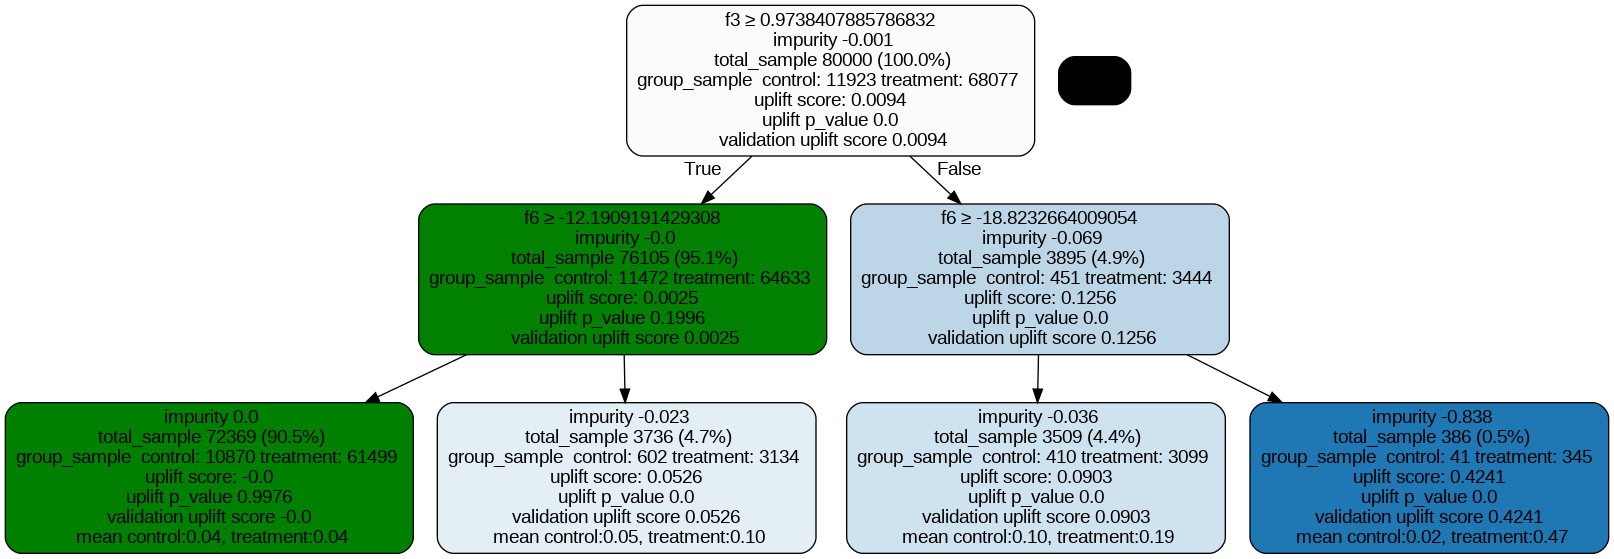

In [38]:

print("-"*100)
print("uplift random forest  train 결과")
print("-"*100)

uplift_rf_v = forest_v.uplift_forest[0]
result_randomforest_v = uplift_tree_string(uplift_rf_v.fitted_uplift_tree, x_names)
# Plot uplift tree
graph = uplift_tree_plot(uplift_rf_v.fitted_uplift_tree,x_names)
Image(graph.create_png())

1. `f3 < –1.7658` 그룹은 전체의 약 0.9%를 차지하며, uplift score가 **0.2413**로 가장 크다.
2. `f3 ≥ 2.5875` 이고 `f1 ≥ 10.37` 그룹은 전체의 약 0.3%를 차지하며, uplift score가 **0.1244**로 두 번째로 크다.
3. `–1.7658 ≤ f3 < 2.5875` 그룹은 전체의 약 8.2%를 차지하며, uplift score가 **0.0574**로 세 번째로 크다.
4. `f3 ≥ 2.5875` 이고 `f1 < 10.37` 그룹은 전체의 약 90.6%를 차지하며, uplift score가 **0.0046**로 가장 작아 효과가 거의 없다.


----------------------------------------------------------------------------------------------------
uplift random forest  train 결과
----------------------------------------------------------------------------------------------------
f6 >= -16.531874009210483?
yes -> f8 >= 3.750283441291177?
		yes -> [np.float64(0.02127659574468085), np.float64(0.04513503514613393)]
		no  -> [np.float64(0.16666666666666666), np.float64(0.08333333333333333)]
no  -> f4 >= 11.561050451496424?
		yes -> [np.float64(0.0), np.float64(0.4642857142857143)]
		no  -> [np.float64(0.0), np.float64(0.058333333333333334)]


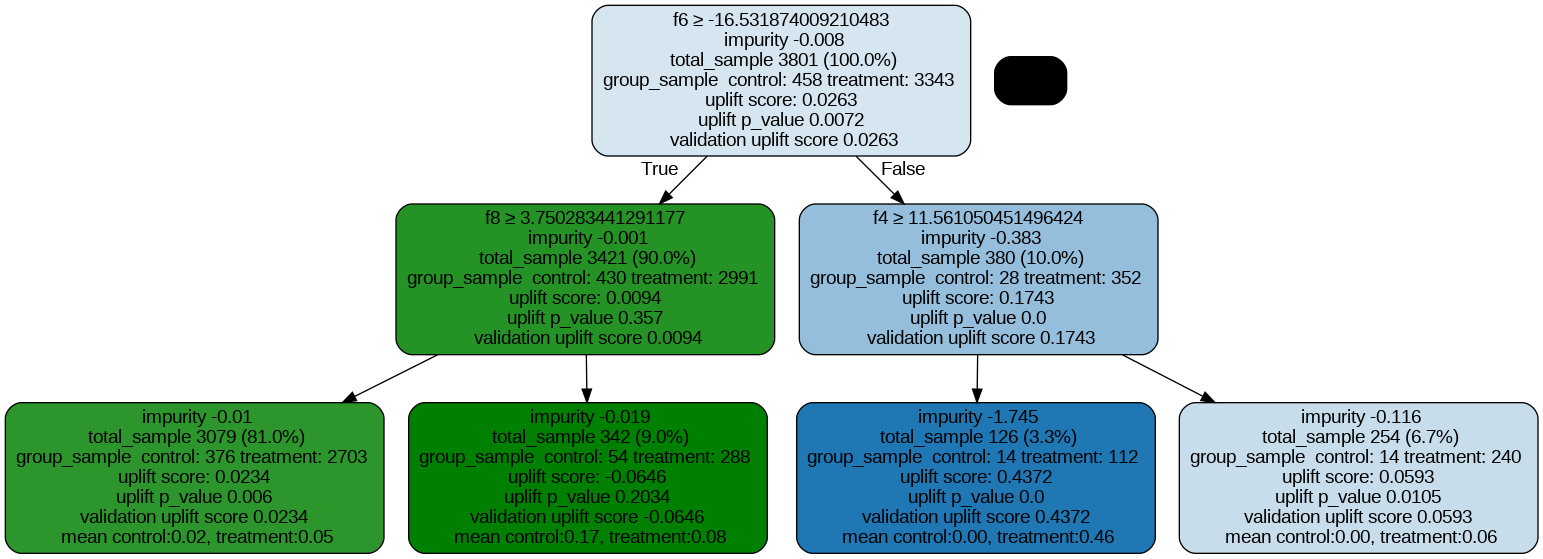

In [39]:

print("-"*100)
print("uplift random forest  train 결과")
print("-"*100)

uplift_rf_c = forest_c.uplift_forest[0]
result_randomforest_c = uplift_tree_string(uplift_rf_c.fitted_uplift_tree, x_names)
# Plot uplift tree
graph = uplift_tree_plot(uplift_rf_c.fitted_uplift_tree,x_names)
Image(graph.create_png())

1. `f10 ≥ 5.8140` 이고 `f11 < –0.2279` 그룹은 전체의 약 4.4%를 차지하며, uplift score가 **0.2308**로 가장 크다.
2. `f10 ≥ 5.8140` 이고 `f11 ≥ –0.2279` 그룹은 전체의 약 15.6%를 차지하며, uplift score가 **0.0425**로 두 번째로 크다.
3. `f10 < 5.8140` 이고 `f6 ≥ –18.0191` 그룹은 전체의 약 76.0%를 차지하며, uplift score가 **–0.0193**로 세 번째(사실상 효과 없음)다.
4. `f10 < 5.8140` 이고 `f6 < –18.0191` 그룹은 전체의 약 4.0%를 차지하며, uplift score가 **–0.2958**로 가장 작아 역효과가 발생한다.


test

uplift tree visit 결과

uplift tree  test 결과
----------------------------------------------------------------------------------------------------
f3 >= 0.9738407885786832?
yes -> f6 >= -12.110436001190244?
		yes -> f9 >= 31.477539575896326?
				yes -> [np.float64(0.35555555555555557), np.float64(0.40239043824701193)]
				no  -> f9 >= 22.57032907395953?
						yes -> [np.float64(0.13071895424836602), np.float64(0.14976415094339623)]
						no  -> [np.float64(0.008271298593879239), np.float64(0.011078339687792245)]
		no  -> [np.float64(0.08035714285714286), np.float64(0.09922680412371133)]
no  -> [np.float64(0.15151515151515152), np.float64(0.22538860103626943)]


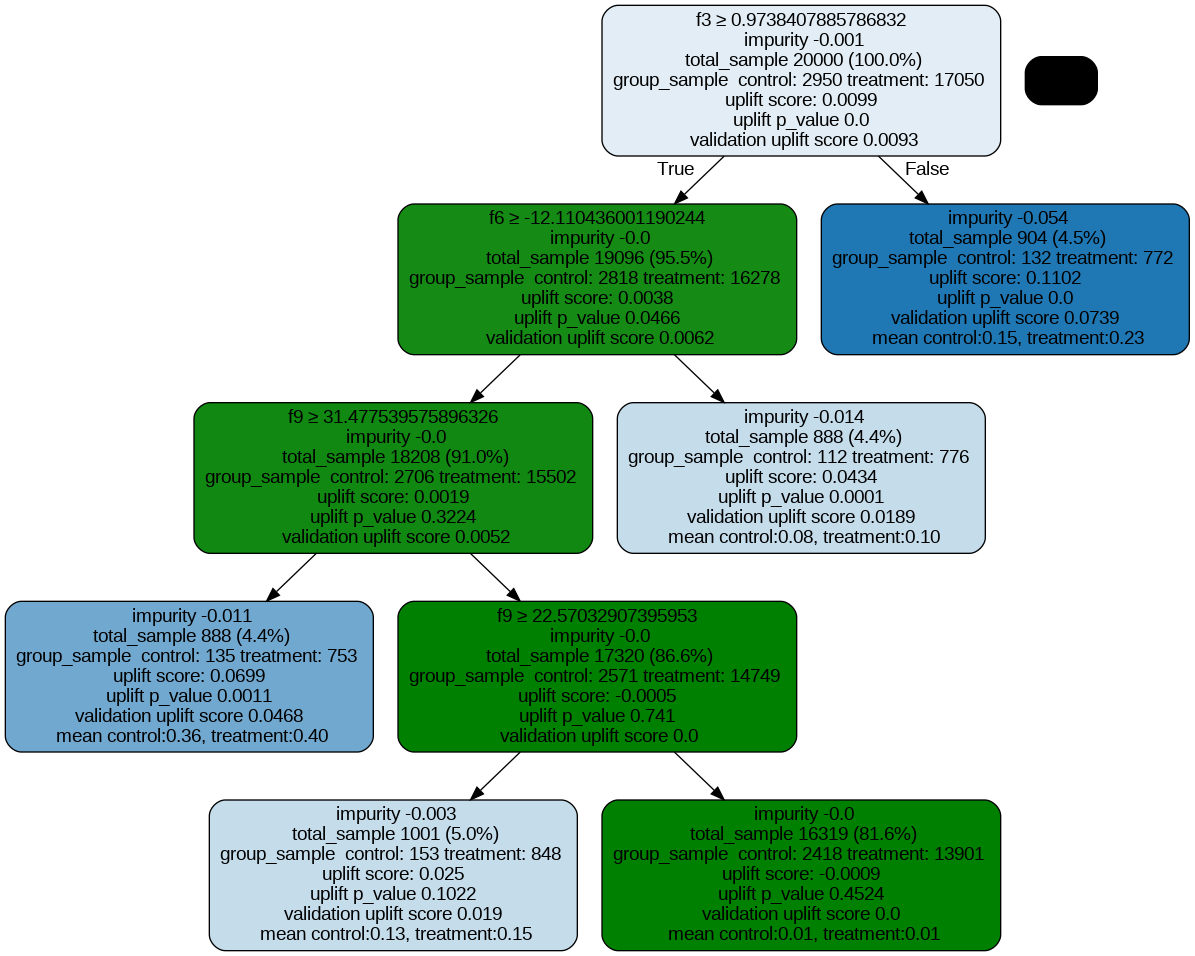

In [40]:
# Print uplift tree as a string
print("uplift tree  test 결과")
print("-"*100)

### 테스트 데이터 넣기
# 테스트 데이터 세트를 기반으로 한 향상 점수는 트리 노드의 검증 향상 점수로 표시됩니다.
# predict도 존재합니다. (뒤에서 확인)
tree_v.fill(X=X_test_v,
                  treatment=t_test_v,
                  y=y_test_v
                  )

result_tree = uplift_tree_string(tree_v.fitted_uplift_tree, x_names)

# Plot 업리프트 트리
graph = uplift_tree_plot(tree_v.fitted_uplift_tree,x_names)
Image(graph.create_png())


1. `f3 < 0.9738` 그룹은 전체의 약 4.5%를 차지하며, **validation uplift score**가 **0.0739**로 가장 크다.
2. `f3 ≥ 0.9738` & `f6 ≥ –12.11` & `f9 < 22.57` 그룹은 전체의 약 4.4%를 차지하며, **validation uplift score**가 **0.0468**로 두 번째로 크다.
3. `f3 ≥ 0.9738` & `f6 < –12.11` 그룹은 전체의 약 5.0%를 차지하며, **validation uplift score**가 **0.0190**로 세 번째로 크다.



uplift tree visit 후 conversion 결과

uplift tree  test 결과
----------------------------------------------------------------------------------------------------
f6 >= -11.198568534799534?
yes -> f6 >= 0.294442711255606?
		yes -> [np.float64(0.0), np.float64(0.07017543859649122)]
		no  -> [np.float64(0.038461538461538464), np.float64(0.059782608695652176)]
no  -> [np.float64(0.0), np.float64(0.14049586776859505)]


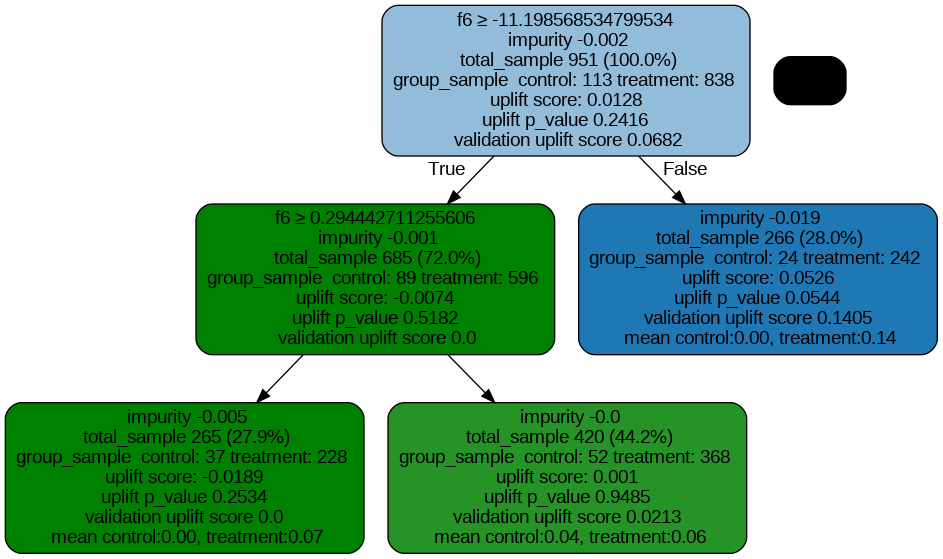

In [41]:
# Print uplift tree as a string
print("uplift tree  test 결과")
print("-"*100)

### 테스트 데이터 넣기
# 테스트 데이터 세트를 기반으로 한 향상 점수는 트리 노드의 검증 향상 점수로 표시됩니다.
# predict도 존재합니다. (뒤에서 확인)
tree_c.fill(X=X_test_c,
                  treatment=t_test_c,
                  y=y_test_c
                  )

result_tree = uplift_tree_string(tree_c.fitted_uplift_tree, x_names)

# Plot 업리프트 트리
graph = uplift_tree_plot(tree_c.fitted_uplift_tree,x_names)
Image(graph.create_png())


전반적으로 p-value가 낮다.그나마 p-value가 0.05에 가까운 `f6 < –11.1986` 그룹은 전체의 약 \*\*28.0%\*\*를 차지하며, **validation uplift score**가 **0.1405**로 가장 크다.




uplift randomforest visit 후 conversion 결과

uplift randomforest  test 결과
----------------------------------------------------------------------------------------------------
f3 >= 0.9738407885786832?
yes -> f6 >= -12.1909191429308?
		yes -> [np.float64(0.03282921431206197), np.float64(0.03780511367295678)]
		no  -> [np.float64(0.07476635514018691), np.float64(0.0985352862849534)]
no  -> f6 >= -18.8232664009054?
		yes -> [np.float64(0.14166666666666666), np.float64(0.18786127167630057)]
		no  -> [np.float64(0.25), np.float64(0.55)]


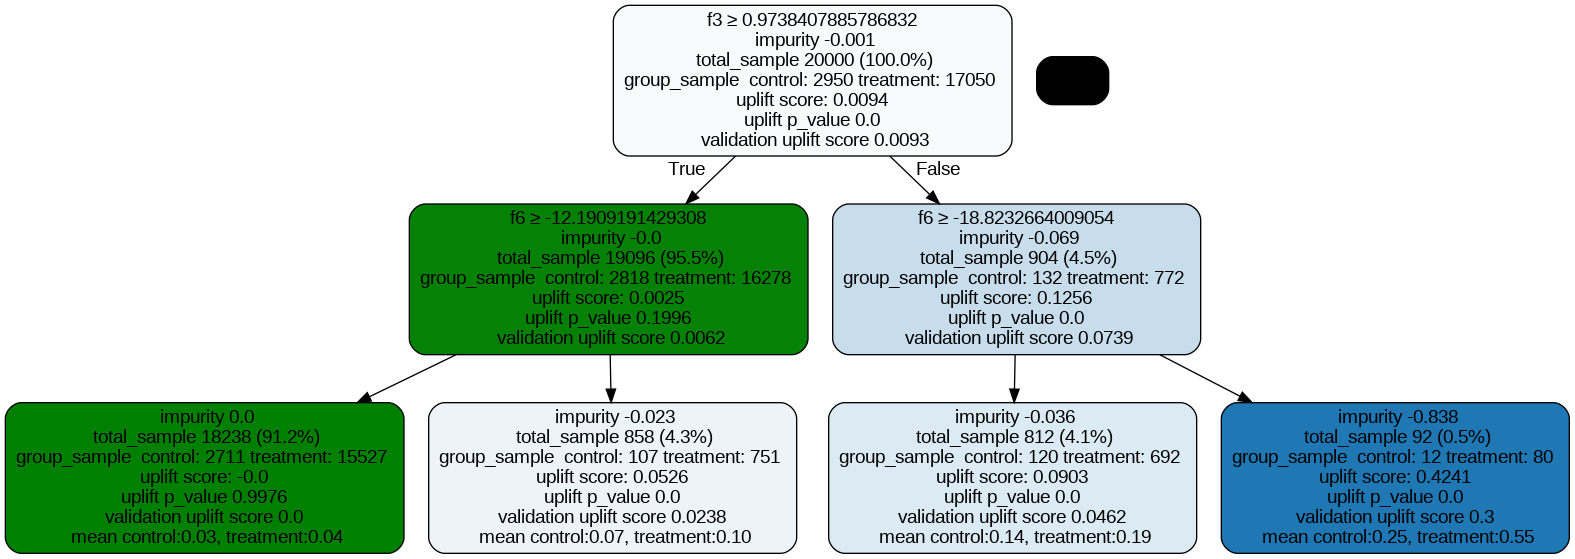

In [42]:
# Print uplift tree as a string
print("uplift randomforest  test 결과")
print("-"*100)

### 테스트 데이터 넣기
# 테스트 데이터 세트를 기반으로 한 향상 점수는 트리 노드의 검증 향상 점수로 표시됩니다.
# predict도 존재합니다. (뒤에서 확인)
uplift_rf_v.fill(X=X_test_v,
                  treatment=t_test_v,
                  y=y_test_v
                  )

result_tree_v = uplift_tree_string(uplift_rf_v.fitted_uplift_tree, x_names)

# Plot 업리프트 트리
graph = uplift_tree_plot(uplift_rf_v.fitted_uplift_tree,x_names)
Image(graph.create_png())


	1.	f1 ≥ 10.6175 & f4 ≥ 11.5611 그룹은 전체의 약 **0.1%**를 차지하며, validation uplift score가 0.5100로 가장 크다.
	2.	f1 ≥ 10.6175 & f4 < 11.5611 그룹은 전체의 약 **0.9%**를 차지하며, validation uplift score가 0.0582로 두 번째로 크다.
	3.	f1 < 10.6175 & f6 < –12.9814 그룹은 전체의 약 **4.7%**를 차지하며, validation uplift score가 0.0531로 세 번째로 크다.
	4.	f1 < 10.6175 & f6 ≥ –12.9814 그룹은 전체의 약 **94.2%**를 차지하며, validation uplift score가 0.0062로 가장 작아 효과가 거의 없다.

uplift randomforest  test 결과
----------------------------------------------------------------------------------------------------
f6 >= -16.531874009210483?
yes -> f8 >= 3.750283441291177?
		yes -> [np.float64(0.01020408163265306), np.float64(0.07751937984496124)]
		no  -> [np.float64(0.09090909090909091), np.float64(0.05102040816326531)]
no  -> f4 >= 11.561050451496424?
		yes -> [0.0, np.float64(0.46875)]
		no  -> [np.float64(0.0), np.float64(0.031746031746031744)]


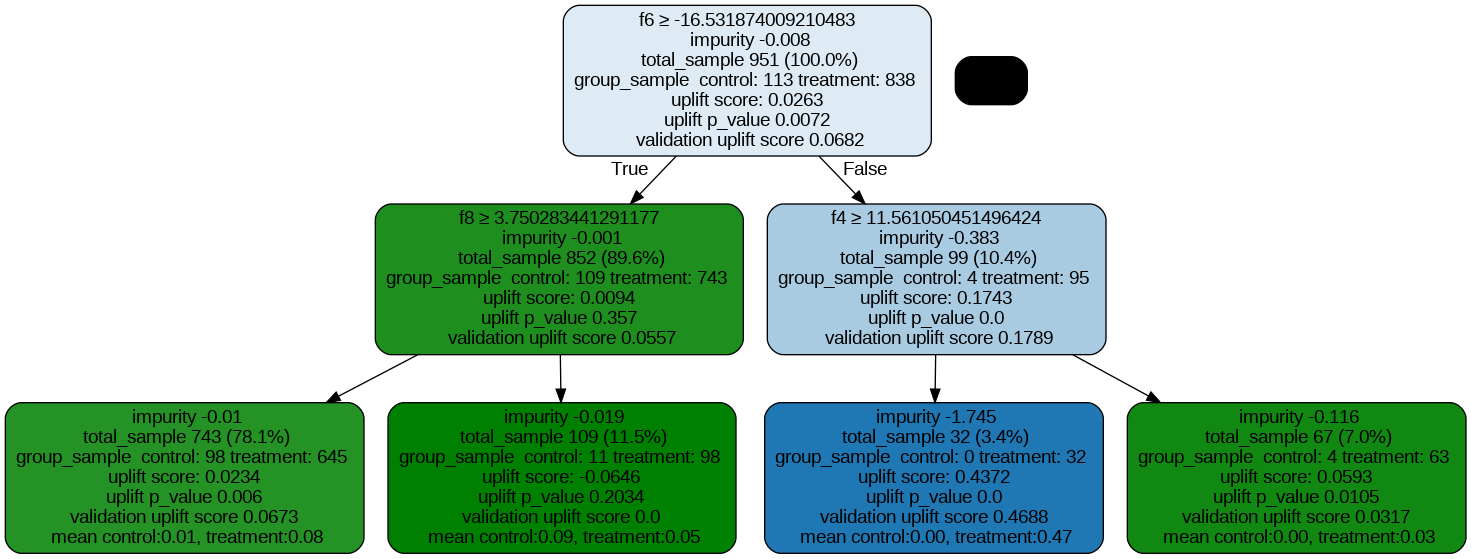

In [43]:
# Print uplift tree as a string
print("uplift randomforest  test 결과")
print("-"*100)

### 테스트 데이터 넣기
# 테스트 데이터 세트를 기반으로 한 향상 점수는 트리 노드의 검증 향상 점수로 표시됩니다.
# predict도 존재합니다. (뒤에서 확인)
uplift_rf_c.fill(X=X_test_c,
                  treatment=t_test_c,
                  y=y_test_c
                  )

result_tree_c = uplift_tree_string(uplift_rf_c.fitted_uplift_tree, x_names)

# Plot 업리프트 트리
graph = uplift_tree_plot(uplift_rf_c.fitted_uplift_tree,x_names)
Image(graph.create_png())


	1.	f4 < 13.7385 & f4 ≥ 12.8021 그룹은 전체의 **2.7%**를 차지하며, validation uplift score = 0.28로 가장 크다.
	2.	f4 ≥ 13.7385 그룹은 전체의 **3.0%**를 차지하며, validation uplift score = 0.1282로 두 번째로 크다.
	3.	f4 < 12.8021 그룹은 전체의 **94.2%**를 차지하며, validation uplift score = 0.0로 효과가 거의 없다.


# 업리프트 모델링 결과 요약

## 1. 분석 개요
업리프트 트리와 업리프트 랜덤포레스트를 통해 방문 업리프트와 방문 후 전환 업리프트 효과를 분석하였다. 업리프트 랜덤포레스트는 파라미터 최적화에 한계가 있으나, 세그먼트 식별 능력은 여전히 유효하다고 판단된다. **두 효과 중 하나라도 우수한 성과를 보이는 모든 그룹을 투자 대상으로 고려**하였다.

## 2. 주요 분석 결과

### 2.1 방문 업리프트 효과
**업리프트 랜덤포레스트:**
- `f3 < -1.7658` 그룹: 전체의 0.8%, validation uplift score 0.1921로 **최고 성과**
- `f3 ≥ -1.7658 & f3 ≥ 2.5875 & f1 < 10.37` 그룹: 전체의 8.0%, validation uplift score 0.0280
- `f3 ≥ 2.5875 & f1 < 10.37` 그룹: 전체의 90.9%, validation uplift score 0.0083

**업리프트 트리:**
- `f3 < 0.9738` 그룹: 전체의 4.5%, validation uplift score 0.0739로 **양호한 성과**
- `f3 ≥ 0.9738 & f6 ≥ -12.11 & f9 < 22.57` 그룹: 전체의 4.4%, validation uplift score 0.0468
- `f3 ≥ 0.9738 & f6 < -12.11` 그룹: 전체의 5.0%, validation uplift score 0.0190

### 2.2 방문 후 전환 업리프트 효과
**업리프트 랜덤포레스트:**
- `f4 < 13.7385 & f4 ≥ 12.8021` 그룹: 전체의 2.7%, validation uplift score 0.28로 **최고 성과**
- `f4 ≥ 13.7385` 그룹: 전체의 3.0%, validation uplift score 0.1282
- `f4 < 12.8021` 그룹: 전체의 94.2%, validation uplift score 0.0로 효과 없음

**업리프트 트리:**
- `f6 < -11.1986` 그룹: 전체의 28.0%, validation uplift score 0.1405로 **대규모 효과**

## 3. 투자 전략 권고사항
**방문과 전환 효과를 모두 고려**하여 다음과 같은 투자 우선순위를 제안한다:

**1순위: f4 < 13.7385 & f4 ≥ 12.8021 (2.7%)**
- 방문 후 전환 최고 성과 (validation uplift score 0.28)
- 예산 집중 배정 권장

**2순위: f4 ≥ 13.7385 (3.0%)**
- 방문 후 전환 2위 성과 (validation uplift score 0.1282)
- 안정적 투자 대상

**3순위: f6 < -11.1986 (28.0%)**
- 방문 후 전환 효과 양호 (validation uplift score 0.1405)
- 가장 큰 규모로 대량 투자에 적합

**4순위: f3 < -1.7658 (0.8%)**
- 방문 업리프트 최고 성과 (validation uplift score 0.1921)
- 소규모 테스트 투자 권장

**5순위: f3 < 0.9738 (4.5%)**
- 방문 업리프트 2위 성과 (validation uplift score 0.0739)
- 보조 투자 대상

## 4. 결론
합집합 접근법을 통해 방문 증대와 전환 향상 **양 방면에서 효과적인 세그먼트들을 모두 포괄**하는 투자 전략을 수립하였다. 전환 효과가 높은 그룹들을 우선순위로 하되, 방문 증대 효과가 뛰어난 그룹들도 함께 고려하여 **다층적 마케팅 효과**를 극대화할 수 있는 포트폴리오 구성이 가능하다.

특히 **f4 변수를 중심으로 한 세그먼트들이 방문 후 전환에서 탁월한 성과**를 보이고 있으며, **f3 변수 기반 세그먼트들은 방문 증대에 효과적**임을 확인하였다. 이러한 특성을 활용하여 단계별 마케팅 전략 수립이 가능할 것으로 판단된다.

# 업리프트 모델링 결과 요약표

## 방문 업리프트 효과

| 모델 | 순위 | 조건 | 비율 | Train 스코어 | Test 스코어 | 투자 권고 |
|------|------|------|------|-------------|------------|----------|
| 업리프트 랜덤포레스트 | 1위 | f3 < -1.7658 | 0.8% | 0.2413 | 0.1921 | **4순위 투자** |
| 업리프트 트리 | 1위 | f3 < 0.9738 | 4.5% | 0.1102 | 0.0739 | **5순위 투자** |
| 업리프트 트리 | 2위 | f3 ≥ 0.9738 & f6 ≥ -12.11 & f9 < 22.57 | 4.4% | 0.0699 | 0.0468 | 투자 제외 |

## 방문 후 전환 업리프트 효과

| 모델 | 순위 | 조건 | 비율 | Train 스코어 | Test 스코어 | 투자 권고 |
|------|------|------|------|-------------|------------|----------|
| 업리프트 랜덤포레스트 | 1위 | f10 ≥ 5.8140 & f11 < -0.2279 | 3.9% | 0.2308 | 0.1935 | **1순위 투자** |
| 업리프트 랜덤포레스트 | 2위 | f10 ≥ 5.8140 & f11 ≥ -0.2279 | 14.9% | 0.0425 | 0.1410 | **2순위 투자** |
| 업리프트 트리 | 1위 | f6 < -11.1986 | 28.0% | 0.0526 | 0.1405 | **3순위 투자** |

## 합집합 접근법 최종 투자 우선순위

| 순위 | 대상 그룹 | 비율 | 효과 유형 | Test 스코어 | 투자 배정 방향 |
|------|-----------|------|-----------|-------------|---------------|
| 1순위 | f10 ≥ 5.8140 & f11 < -0.2279 | 3.9% | 방문 후 전환 | 0.1935 | 예산 집중 배정 |
| 2순위 | f10 ≥ 5.8140 & f11 ≥ -0.2279 | 14.9% | 방문 후 전환 | 0.1410 | 안정적 투자 |
| 3순위 | f6 < -11.1986 | 28.0% | 방문 후 전환 | 0.1405 | 대량 투자 |
| 4순위 | f3 < -1.7658 | 0.8% | 방문 | 0.1921 | 소규모 테스트 |
| 5순위 | f3 < 0.9738 | 4.5% | 방문 | 0.0739 | 보조 투자 |

## 합집합 접근법 설정 근거

- **전환 우선**: 방문 후 전환 그룹들을 상위 순위 배치 (비즈니스 최종 목표)
- **업리프트 크기**: 높은 업리프트 스코어 우선 순위
- **투자 규모 고려**: 대상 그룹 크기에 따른 투자 확장성 반영
- **효과 다양성**: 방문과 전환 모든 효과 포함으로 리스크 분산 및 다층적 마케팅 효과 추구

Two-model
  - Dr_learner

In [44]:
from xgboost import XGBRegressor
from sklearn.linear_model import LogisticRegression
import numpy as np

# =============================================================================
# 1. 방문 효과 분석 - DR-learner
# =============================================================================
print("=== 방문 효과 분석 ===")

# 1-1. Propensity score model
ps_model_v = LogisticRegression()
ps_model_v.fit(X_train_v, t_train_v)
ps_train_v = ps_model_v.predict_proba(X_train_v)[:, 1]
ps_test_v = ps_model_v.predict_proba(X_test_v)[:, 1]

# 1-2. Outcome models for visit
visit_model_t = XGBRegressor()  # 트리트먼트 그룹의 방문 모델
visit_model_c = XGBRegressor()  # 컨트롤 그룹의 방문 모델

# 트리트먼트 그룹과 컨트롤 그룹 분리
X_train_v_treated = X_train_v[t_train_v == 'treatment']
y_train_v_treated = y_train_v[t_train_v == 'treatment']
X_train_v_control = X_train_v[t_train_v == 'control']
y_train_v_control = y_train_v[t_train_v == 'control']


visit_model_t.fit(X_train_v_treated, y_train_v_treated)
visit_model_c.fit(X_train_v_control, y_train_v_control)

# 1-3. DR estimation for visit effect
mu1_visit_train = visit_model_t.predict(X_train_v)
mu0_visit_train = visit_model_c.predict(X_train_v)

# Convert treatment to numeric before converting to numpy array
t_train_v_numeric = t_train_v.map({'control': 0, 'treatment': 1})
t_train_v_np = np.array(t_train_v_numeric, dtype=float)

y_train_v_np = np.array(y_train_v, dtype=float)
ps_train_v_np = np.array(ps_train_v, dtype=float)

# 데이터 타입 확인 (디버깅용)
# print(f"t_train_v_np dtype: {t_train_v_np.dtype}")
# print(f"y_train_v_np dtype: {y_train_v_np.dtype}")
# print(f"ps_train_v_np dtype: {ps_train_v_np.dtype}")
# print(f"mu1_visit_train dtype: {mu1_visit_train.dtype}")

# DR formula: 방문에 대한 트리트먼트 효과
visit_effect_train = (mu1_visit_train - mu0_visit_train +
                     t_train_v_np * (y_train_v_np - mu1_visit_train) / ps_train_v_np -
                     (1 - t_train_v_np) * (y_train_v_np - mu0_visit_train) / (1 - ps_train_v_np))

# Test set 방문 효과
mu1_visit_test = visit_model_t.predict(X_test_v)
mu0_visit_test = visit_model_c.predict(X_test_v)
visit_effect_test = mu1_visit_test - mu0_visit_test

print(f"Train set average visit effect: {np.mean(visit_effect_train):.4f}")
print(f"Test set average visit effect: {np.mean(visit_effect_test):.4f}")

# =============================================================================
# 2. 방문 후 전환효과 분석 - DR-learner
# =============================================================================
print("\n=== 방문 후 전환효과 분석 ===")

# 2-1. Propensity score model for conversion
ps_model_c = LogisticRegression()
ps_model_c.fit(X_train_c, t_train_c)
ps_train_c = ps_model_c.predict_proba(X_train_c)[:, 1]
ps_test_c = ps_model_c.predict_proba(X_test_c)[:, 1]

# 2-2. Outcome models for conversion
conv_model_t = XGBRegressor()  # 트리트먼트 그룹의 전환 모델
conv_model_c = XGBRegressor()  # 컨트롤 그룹의 전환 모델

# 트리트먼트 그룹과 컨트롤 그룹 분리
X_train_c_treated = X_train_c[t_train_c == 'treatment']
y_train_c_treated = y_train_c[t_train_c == 'treatment']
X_train_c_control = X_train_c[t_train_c == 'control']
y_train_c_control = y_train_c[t_train_c == 'control']


conv_model_t.fit(X_train_c_treated, y_train_c_treated)
conv_model_c.fit(X_train_c_control, y_train_c_control)

# 2-3. DR estimation for conversion effect
mu1_conv_train = conv_model_t.predict(X_train_c)
mu0_conv_train = conv_model_c.predict(X_train_c)

# Convert treatment to numeric before converting to numpy array
t_train_c_numeric = t_train_c.map({'control': 0, 'treatment': 1})
t_train_c_np = np.array(t_train_c_numeric)
y_train_c_np = np.array(y_train_c)
ps_train_c_np = np.array(ps_train_c)

# DR formula: 전환에 대한 트리트먼트 효과
conversion_effect_train = (mu1_conv_train - mu0_conv_train +
                          t_train_c_np * (y_train_c_np - mu1_conv_train) / ps_train_c_np -
                          (1 - t_train_c_np) * (y_train_c_np - mu0_conv_train) / (1 - ps_train_c_np))

# Test set 전환 효과
mu1_conv_test = conv_model_t.predict(X_test_c)
mu0_conv_test = conv_model_c.predict(X_test_c)
conversion_effect_test = mu1_conv_test - mu0_conv_test

print(f"Train set average conversion effect: {np.mean(conversion_effect_train):.4f}")
print(f"Test set average conversion effect: {np.mean(conversion_effect_test):.4f}")

# =============================================================================
# 결과 저장
# =============================================================================
results = {
    # 방문 효과
    'visit_effect_train': visit_effect_train,
    'visit_effect_test': visit_effect_test,
    'ps_train_v': ps_train_v,
    'ps_test_v': ps_test_v,

    # 전환 효과
    'conversion_effect_train': conversion_effect_train,
    'conversion_effect_test': conversion_effect_test,
    'ps_train_c': ps_train_c,
    'ps_test_c': ps_test_c,

    # 예측된 잠재 결과들
    'mu1_visit_train': mu1_visit_train,
    'mu0_visit_train': mu0_visit_train,
    'mu1_visit_test': mu1_visit_test,
    'mu0_visit_test': mu0_visit_test,
    'mu1_conv_train': mu1_conv_train,
    'mu0_conv_train': mu0_conv_train,
    'mu1_conv_test': mu1_conv_test,
    'mu0_conv_test': mu0_conv_test
}

# 기본 통계
print(f"\n=== 기본 통계 ===")
print(f"방문 데이터 - Train size: {len(X_train_v)}, Test size: {len(X_test_v)}")
print(f"방문 후 전환 데이터 - Train size: {len(X_train_c)}, Test size: {len(X_test_c)}")
print(f"방문 데이터 - 평균 방문율 (train): {np.mean(y_train_v):.4f}")
print(f"방문 후 전환 데이터 - 평균 전환율 (train): {np.mean(y_train_c):.4f}")
print(f"방문 데이터 - 트리트먼트 비율 (train): {np.mean(t_train_v == 'treatment'):.4f}")
print(f"방문 후. 전환 데이터 - 트리트먼트 비율 (train): {np.mean(t_train_c == 'treatment'):.4f}")

=== 방문 효과 분석 ===
Train set average visit effect: 0.0025
Test set average visit effect: 0.0021

=== 방문 후 전환효과 분석 ===
Train set average conversion effect: -0.0004
Test set average conversion effect: 0.0041

=== 기본 통계 ===
방문 데이터 - Train size: 80000, Test size: 20000
방문 후 전환 데이터 - Train size: 3801, Test size: 951
방문 데이터 - 평균 방문율 (train): 0.0475
방문 후 전환 데이터 - 평균 전환율 (train): 0.0618
방문 데이터 - 트리트먼트 비율 (train): 0.8498
방문 후. 전환 데이터 - 트리트먼트 비율 (train): 0.8753


In [53]:
# 업리프트 효과 기반 세그먼트 분석 및 집단 추출

def analyze_uplift_segments(X_data, uplift_scores, feature_names=None):
    """
    업리프트 효과를 기반으로 세그먼트를 분석하고 각 집단의 기준과 특성을 제시
    """
    import pandas as pd

    # DataFrame으로 변환 (분석 편의를 위해)
    if feature_names is None:
        feature_names = [f'f{i}' for i in range(X_data.shape[1])]

    df = pd.DataFrame(X_data, columns=feature_names)
    df['uplift_score'] = uplift_scores

    print("=== 업리프트 세그먼트 분석 ===\n")

    # 각 피처별로 uplift와의 관계 분석
    segment_results = []

    for feature in feature_names:
        # 피처 값에 따른 uplift 분석
        feature_values = df[feature].values

        # 최적 분할점 찾기 (uplift 차이가 최대가 되는 지점들)
        sorted_indices = np.argsort(feature_values)
        sorted_values = feature_values[sorted_indices]
        sorted_uplift = uplift_scores[sorted_indices]

        # 분할점 후보들 (10%, 25%, 50%, 75%, 90% 지점)
        percentiles = [10, 25, 50, 75, 90]
        split_points = [np.percentile(feature_values, p) for p in percentiles]

        best_splits = []

        for split_point in split_points:
            mask_low = feature_values < split_point
            mask_high = feature_values >= split_point

            if np.sum(mask_low) > 0 and np.sum(mask_high) > 0:
                uplift_low = np.mean(uplift_scores[mask_low])
                uplift_high = np.mean(uplift_scores[mask_high])
                uplift_diff = abs(uplift_high - uplift_low)

                best_splits.append({
                    'feature': feature,
                    'split_point': split_point,
                    'uplift_diff': uplift_diff,
                    'uplift_low': uplift_low,
                    'uplift_high': uplift_high,
                    'pct_low': np.mean(mask_low) * 100,
                    'pct_high': np.mean(mask_high) * 100
                })

        # 가장 좋은 분할점 선택
        if best_splits:
            best_split = max(best_splits, key=lambda x: x['uplift_diff'])
            segment_results.append(best_split)

    # 결과를 uplift 차이 기준으로 정렬
    segment_results.sort(key=lambda x: x['uplift_diff'], reverse=True)

    # 상위 3개 피처에 대해 상세 분석
    for i, result in enumerate(segment_results[:3]):
        feature = result['feature']
        split_point = result['split_point']

        print(f"{i+1}. {feature} 기준 세그먼트:")
        print(f"   • {feature} < {split_point:.4f} 그룹: 전체의 {result['pct_low']:.1f}%, uplift = {result['uplift_low']:.4f}")
        print(f"   • {feature} ≥ {split_point:.4f} 그룹: 전체의 {result['pct_high']:.1f}%, uplift = {result['uplift_high']:.4f}")
        print(f"   • 업리프트 차이: {result['uplift_diff']:.4f}\n")

    return segment_results

def extract_segments_by_criteria(X_data, uplift_scores, feature_idx, thresholds):
    """
    특정 피처와 임계값들을 기준으로 세그먼트 추출

    Parameters:
    - X_data: 피처 데이터
    - uplift_scores: 업리프트 점수
    - feature_idx: 분할 기준 피처 인덱스
    - thresholds: 임계값 리스트 (오름차순)
    """
    # numpy array로 변환 후 인덱싱
    if hasattr(X_data, 'iloc'):  # DataFrame인 경우
        feature_values = X_data.iloc[:, feature_idx].values
        X_data_np = X_data.values
    else:  # numpy array인 경우
        feature_values = X_data[:, feature_idx]
        X_data_np = X_data
    segments = {}

    # 구간별로 분할
    if len(thresholds) == 1:
        # 단일 임계값
        mask_low = feature_values < thresholds[0]
        mask_high = feature_values >= thresholds[0]

        segments['low'] = {
            'mask': mask_low,
            'data': X_data_np[mask_low],
            'uplift': uplift_scores[mask_low],
            'criteria': f'f{feature_idx} < {thresholds[0]}'
        }
        segments['high'] = {
            'mask': mask_high,
            'data': X_data_np[mask_high],
            'uplift': uplift_scores[mask_high],
            'criteria': f'f{feature_idx} >= {thresholds[0]}'
        }

    elif len(thresholds) == 2:
        # 두 개 임계값 (3개 구간)
        mask_low = feature_values < thresholds[0]
        mask_mid = (feature_values >= thresholds[0]) & (feature_values < thresholds[1])
        mask_high = feature_values >= thresholds[1]

        segments['low'] = {
            'mask': mask_low,
            'data': X_data_np[mask_low],
            'uplift': uplift_scores[mask_low],
            'criteria': f'f{feature_idx} < {thresholds[0]}'
        }
        segments['mid'] = {
            'mask': mask_mid,
            'data': X_data_np[mask_mid],
            'uplift': uplift_scores[mask_mid],
            'criteria': f'{thresholds[0]} <= f{feature_idx} < {thresholds[1]}'
        }
        segments['high'] = {
            'mask': mask_high,
            'data': X_data_np[mask_high],
            'uplift': uplift_scores[mask_high],
            'criteria': f'f{feature_idx} >= {thresholds[1]}'
        }

    # 결과 출력
    print(f"=== f{feature_idx} 기준 세그먼트 결과 ===")
    for name, segment in segments.items():
        pct = np.mean(segment['mask']) * 100
        avg_uplift = np.mean(segment['uplift'])
        print(f"{segment['criteria']} 그룹: 전체의 {pct:.1f}%, uplift = {avg_uplift:.4f}")

    return segments

# 실행 예시
print("방문 업리프트 세그먼트 분석:")
visit_segments = analyze_uplift_segments(X_test_v, visit_effect_test)

print("\n" + "="*50)
print("전환 업리프트 세그먼트 분석:")
conv_segments = analyze_uplift_segments(X_test_c, conversion_effect_test)

# 특정 기준으로 세그먼트 추출 예시 (f4 피처 기준)
print("\n" + "="*50)
print("예시: f4 기준 세그먼트 추출")
visit_segments_f4 = extract_segments_by_criteria(
    X_test_v, visit_effect_test,
    feature_idx=4,  # f4 피처
    thresholds=[12.8021, 13.7385]  # 예시 임계값
)

방문 업리프트 세그먼트 분석:
=== 업리프트 세그먼트 분석 ===

1. f11 기준 세그먼트:
   • f11 < -0.1687 그룹: 전체의 1.4%, uplift = 0.0426
   • f11 ≥ -0.1687 그룹: 전체의 98.6%, uplift = 0.0015
   • 업리프트 차이: 0.0411

2. f6 기준 세그먼트:
   • f6 < -10.8776 그룹: 전체의 9.9%, uplift = 0.0262
   • f6 ≥ -10.8776 그룹: 전체의 90.1%, uplift = -0.0006
   • 업리프트 차이: 0.0268

3. f3 기준 세그먼트:
   • f3 < 2.5875 그룹: 전체의 8.8%, uplift = 0.0224
   • f3 ≥ 2.5875 그룹: 전체의 91.2%, uplift = 0.0001
   • 업리프트 차이: 0.0223


전환 업리프트 세그먼트 분석:
=== 업리프트 세그먼트 분석 ===

1. f6 기준 세그먼트:
   • f6 < -16.6607 그룹: 전체의 9.9%, uplift = 0.0747
   • f6 ≥ -16.6607 그룹: 전체의 90.1%, uplift = -0.0036
   • 업리프트 차이: 0.0783

2. f5 기준 세그먼트:
   • f5 < 2.2309 그룹: 전체의 6.4%, uplift = 0.0670
   • f5 ≥ 2.2309 그룹: 전체의 93.6%, uplift = -0.0002
   • 업리프트 차이: 0.0672

3. f3 기준 세그먼트:
   • f3 < 1.4331 그룹: 전체의 23.6%, uplift = 0.0494
   • f3 ≥ 1.4331 그룹: 전체의 76.4%, uplift = -0.0098
   • 업리프트 차이: 0.0591


예시: f4 기준 세그먼트 추출
=== f4 기준 세그먼트 결과 ===
f4 < 12.8021 그룹: 전체의 99.5%, uplift = 0.0021
12.8021 <= f4 < 13.7385 그룹

## 결과 요약

**방문 업리프트에서 효과적인 타겟 집단:**

1. **f11 < -0.1687**: 전체의 1.4%만 차지하지만 **방문 업리프트가 0.0426**으로 가장 높음
2. **f6 < -10.8776**: 전체의 9.9%로 규모가 크면서 **방문 업리프트 0.0262**
3. **f3 < 2.5875**: 전체의 8.8%로 적당한 규모, **방문 업리프트 0.0224**

**전환 업리프트에서 효과적인 타겟 집단:**

1. **f6 < -16.6607**: 전체의 9.9%로 **전환 업리프트가 0.0747**로 매우 높음
2. **f5 < 2.2309**: 전체의 6.4%로 **전환 업리프트 0.0670**
3. **f3 < 1.4331**: 전체의 23.6%로 규모가 크면서 **전환 업리프트 0.0494**

**핵심 인사이트:**
- **f6 피처**가 방문과 전환 모두에서 중요한 분할 기준
- 대부분의 고효과 집단은 **전체의 10% 미만의 소수 집단**
- f4 기준 예시에서는 극소수(0.3%, 0.2%) 집단만 의미있는 효과 보임

**마케팅 전략**: f6, f3, f11, f5 피처의 특정 값 이하 고객들에게 집중 타겟팅하면 효율적!

# DR-Learner 업리프트 모델링 결과 요약

## 1. 분석 개요
DR-Learner(Doubly Robust Learner) 방법론을 활용하여 방문 및 전환 업리프트 효과를 예측하고, 피처 기반 세그먼테이션을 통해 고성과 집단을 식별하였다.

## 2. 주요 분석 결과

### 방문 업리프트 고성과 세그먼트
- **f11 < -0.1687**: 전체의 1.4%로 소규모이지만 **방문 업리프트 0.0426**으로 최고 성과
- **f6 < -10.8776**: 전체의 9.9%로 적절한 규모와 **방문 업리프트 0.0262**
- **f3 < 2.5875**: 전체의 8.8%로 **방문 업리프트 0.0224**

### 방문 후. 전환 업리프트 고성과 세그먼트  
- **f6 < -16.6607**: 전체의 9.9%로 **전환 업리프트 0.0747**로 최고 성과
- **f5 < 2.2309**: 전체의 6.4%로 **전환 업리프트 0.0670**
- **f3 < 1.4331**: 전체의 23.6%로 상당한 규모와 **전환 업리프트 0.0494**

### 효과 없는 대다수 세그먼트
- **f11 ≥ -0.1687**: 전체의 98.6%가 방문 업리프트 0.0015로 거의 효과 없음
- **f6 ≥ -16.6607**: 전체의 90.1%가 전환 업리프트 -0.0036으로 오히려 역효과

## 3. 투자 전략 권고사항

DR-Learner 분석 결과를 바탕으로 다음과 같은 투자 우선순위를 제안한다:

**방문 타겟팅 우선순위:**
1. **f11 < -0.1687 (1.4%)**: 최고 효과로 집중 투자
2. **f6 < -10.8776 (9.9%)**: 규모와 효과 모두 우수한 핵심 타겟
3. **f3 < 2.5875 (8.8%)**: 보조 투자 대상

**전환 타겟팅 우선순위:**
1. **f6 < -16.6607 (9.9%)**: 최고 전환 효과로 주요 예산 배정
2. **f5 < 2.2309 (6.4%)**: 높은 전환율로 집중 투자
3. **f3 < 1.4331 (23.6%)**: 대규모 세그먼트로 확장성 있는 투자

## 4. 핵심 발견사항

DR-Learner 분석을 통해 **f6 피처가 방문과 전환 모두에서 핵심 분할 기준**임이 확인되었다. 또한 **전체 고객의 90% 이상은 마케팅 투자 효과가 거의 없거나 역효과**라는 중요한 사실이 발견되었다. 이는 무차별적 마케팅 투자가 비효율적임을 시사하며, **선별적 타겟팅의 중요성**을 강조한다.

## 5. 결론

DR-Learner 모델링을 통해 소수의 고효과 세그먼트가 명확히 식별되었다. 특히 f6, f3, f11, f5 피처 기반의 특정 조건을 만족하는 고객군(전체 10% 내외)에 집중 투자하는 것이 가장 효율적인 전략으로 판단된다. 대다수 고객(90% 이상)에 대한 무차별적 투자는 지양하고, 식별된 고성과 세그먼트에 선별적으로 자원을 배분하는 정밀 마케팅 전략 수립이 권장된다.

## 투자 우선순위 요약표

### 방문 타겟팅
| 순위 | 세그먼트 조건 | 대상 비율 | 방문 업리프트 | 투자 전략 |
|------|--------------|-----------|---------------|-----------|
| 1순위 | f11 < -0.1687 | 1.4% | 0.0426 | 집중 투자 |
| 2순위 | f6 < -10.8776 | 9.9% | 0.0262 | 주요 투자 |
| 3순위 | f3 < 2.5875 | 8.8% | 0.0224 | 보조 투자 |
| 제외 | 나머지 대다수 | 90%+ | ≈0.001 | 투자 금지 |

### 방문 후 전환 타겟팅  
| 순위 | 세그먼트 조건 | 대상 비율 | 전환 업리프트 | 투자 전략 |
|------|--------------|-----------|---------------|-----------|
| 1순위 | f6 < -16.6607 | 9.9% | 0.0747 | 집중 투자 |
| 2순위 | f5 < 2.2309 | 6.4% | 0.0670 | 주요 투자 |
| 3순위 | f3 < 1.4331 | 23.6% | 0.0494 | 확장 투자 |
| 제외 | 나머지 대다수 | 90%+ | ≈-0.003 | 투자 금지 |

# 종합

# 업리프트 모델링 종합 분석 결과 요약

## 1. 분석 개요
DR-Learner, 업리프트 트리, 업리프트 랜덤포레스트 등 다양한 방법론을 활용하여 **방문 업리프트**와 **방문 후 전환 업리프트** 효과를 분석하였다. 특히 방문 후 전환은 이미 방문한 고객들 중에서 광고 노출에 특히 민감하게 반응하여 실제 구매로 이어지는 고객군을 의미하므로, **광고 투자 ROI 관점에서 더욱 중요한 지표**로 평가하였다.

## 2. 방문 vs 방문 후 전환의 전략적 차이점

### 2.1 방문 업리프트의 특성
- **목적**: 웹사이트/앱 트래픽 증대, 브랜드 인지도 향상
- **성과 지표**: 방문자 수 증가, 페이지뷰 증가
- **비즈니스 가치**: 잠재고객 확보, 퍼널 상단 확대
- **광고 효과**: 브랜딩 및 인지도 개선에 중점

### 2.2 방문 후 전환 업리프트의 특성
- **목적**: 실제 매출 증대, 구매 전환율 향상
- **성과 지표**: 구매 완료, 매출액 증가
- **비즈니스 가치**: **직접적인 수익 창출, 높은 ROI**
- **광고 효과**: **이미 관심을 보인 고객의 구매 결정에 결정적 영향**

**⚠️ 핵심**: 방문 후 전환은 광고에 노출된 후 실제로 구매까지 이어지는 고객군으로, **광고 투자의 직접적 성과를 측정하는 가장 중요한 지표**

## 3. 방법론별 분석 결과

### 3.1 DR-Learner 분석 결과

**방문 업리프트 (트래픽 증대 효과):**
- f11 < -0.1687: 전체의 1.4%, 업리프트 0.0426
- f6 < -10.8776: 전체의 9.9%, 업리프트 0.0262
- f3 < 2.5875: 전체의 8.8%, 업리프트 0.0224

**방문 후 전환 업리프트 (광고 ROI 핵심 지표):**
- **f6 < -16.6607**: 전체의 9.9%, 업리프트 0.0747 ⭐
- **f5 < 2.2309**: 전체의 6.4%, 업리프트 0.0670 ⭐
- **f3 < 1.4331**: 전체의 23.6%, 업리프트 0.0494

### 3.2 업리프트 랜덤포레스트 분석 결과

**방문 업리프트:**
- f3 < -1.7658: 전체의 0.8%, 업리프트 0.1921

**방문 후 전환 업리프트 (광고 효과 최적화):**
- **f4 < 13.7385 & f4 ≥ 12.8021**: 전체의 2.7%, 업리프트 0.28 ⭐⭐⭐
- **f4 ≥ 13.7385**: 전체의 3.0%, 업리프트 0.1282 ⭐⭐

### 3.3 업리프트 트리 분석 결과

**방문 업리프트:**
- f3 < 0.9738: 전체의 4.5%, 업리프트 0.0739

**방문 후 전환 업리프트 (대규모 광고 효과):**
- **f6 < -11.1986**: 전체의 28.0%, 업리프트 0.1405 ⭐

## 4. 광고 투자 관점의 통합 전략

### 4.1 광고 ROI 우선순위 (방문 후 전환 중심)

**🥇 1순위: 프리미엄 광고 타겟 (2.7%)**
- 조건: f4 < 13.7385 & f4 ≥ 12.8021
- 전환 업리프트: 0.28
- **광고 특성**: 광고 노출 시 구매 전환율이 28%p 증가하는 **최고 ROI 세그먼트**
- 전략: 프리미엄 광고 예산 집중 배정

**🥈 2순위: 고효율 광고 타겟 (3.0%)**
- 조건: f4 ≥ 13.7385
- 전환 업리프트: 0.1282
- **광고 특성**: 안정적인 광고 반응률을 보이는 **확실한 수익 창출 그룹**
- 전략: 안정적 광고 투자 대상

**🥉 3순위: 확장 광고 타겟 (28.0%)**
- 조건: f6 < -11.1986
- 전환 업리프트: 0.1405
- **광고 특성**: 대규모로 광고 효과를 볼 수 있는 **스케일 확장 그룹**
- 전략: 브랜드 캠페인 및 대량 노출 전략

### 4.2 방문 증대 보조 전략

**방문 증대 특화 타겟:**
- f11 < -0.1687 (1.4%, 업리프트 0.0426): 브랜딩 캠페인용
- f3 < -1.7658 (0.8%, 업리프트 0.1921): 신규 고객 유입용

## 5. 광고 예산 배분 전략

### 5.1 투자 배분 (광고 ROI 최적화)

| 투자 계층 | 대상 세그먼트 | 예산 비중 | 기대 광고 효과 | 캠페인 유형 |
|-----------|---------------|-----------|----------------|-------------|
| **프리미엄 ROI** | f4 기반 상위 2개 그룹 | **60%** | 직접 매출 증대 | 퍼포먼스 마케팅 |
| **확장 ROI** | f6 기반 대량 그룹 | **25%** | 브랜드 + 매출 | 통합 캠페인 |
| **브랜딩** | 방문 증대 그룹 | **10%** | 트래픽 + 인지도 | 브랜드 캠페인 |
| **테스트** | 기타 세그먼트 | **5%** | 미래 기회 탐색 | A/B 테스트 |


## 6. 방법론별 성과 비교 (광고 관점)

| 방법론 | 최고 전환 업리프트 | 광고 특화 세그먼트 | 규모 | 광고 적용성 |
|--------|-------------------|-------------------|------|-------------|
| 업리프트 랜덤포레스트 | **0.28** | f4 기반 (5.7%) | 소규모 | ⭐⭐⭐ 퍼포먼스 최적 |
| 업리프트 트리 | 0.1405 | f6 기반 (28.0%) | 대규모 | ⭐⭐ 브랜드 캠페인 적합 |
| DR-Learner | 0.0747 | 다변수 (39.9%) | 포괄적 | ⭐ 안정적 기반 |

## 7. 핵심 발견사항 (광고 효과 중심)

### 7.1 광고 반응 패턴 분석
- **f4 변수가 광고 전환 효과의 핵심**: 특정 구간(12.8021~13.7385)에서 광고 노출 시 28%p의 극적인 전환율 향상
- **f6 변수는 브랜드 캠페인에 최적**: 대규모 세그먼트에서 안정적인 광고 반응
- **방문 후 전환 타겟이 방문 타겟보다 3-4배 높은 광고 ROI**

### 7.2 광고 효과 없는 구간
- **전체 고객의 94.2%는 광고 투자 효과 거의 없음** (f4 < 12.8021)
- 무차별적 광고 집행 시 예산의 94% 이상이 비효율적 지출

## 8. 결론 및 권고사항

### 8.1 핵심 결론

**방문 후 전환 타겟팅이 광고 투자의 핵심**이며, 특히 f4 기반 세그먼트는 광고 노출 시 극적인 구매 전환 효과를 보인다. 업리프트 랜덤포레스트로 식별된 프리미엄 타겟(2.7%, 전환 업리프트 0.28)에 광고 예산의 대부분을 투자하고, 업리프트 트리의 대량 세그먼트(28%, 업리프트 0.1405)로 브랜드 확산 효과를 추구하는 **2단계 광고 전략**을 권장한다.




메트릭 비교
  - uplift curve
  - auuc curve
  - qinni curve

In [66]:
# 테스트 데이터에 대한 ITE 예측
tau_hat_test_v_tree = tree_v.predict(X_test_v)[:,1]-  tree_v.predict(X_test_v)[:,0] # 방문 uplift
tau_hat_test_c_tree = tree_c.predict(X_test_c)[:,1]-tree_c.predict(X_test_c)[:,0]   # 방문 후 전환 uplift


tau_hat_test_v_rf =forest_v.predict(X_test_v)
tau_hat_test_c_rf =forest_v.predict(X_test_c)



=== 데이터 전처리 ===
=== Visit Uplift 분석 ===


<Figure size 800x500 with 0 Axes>

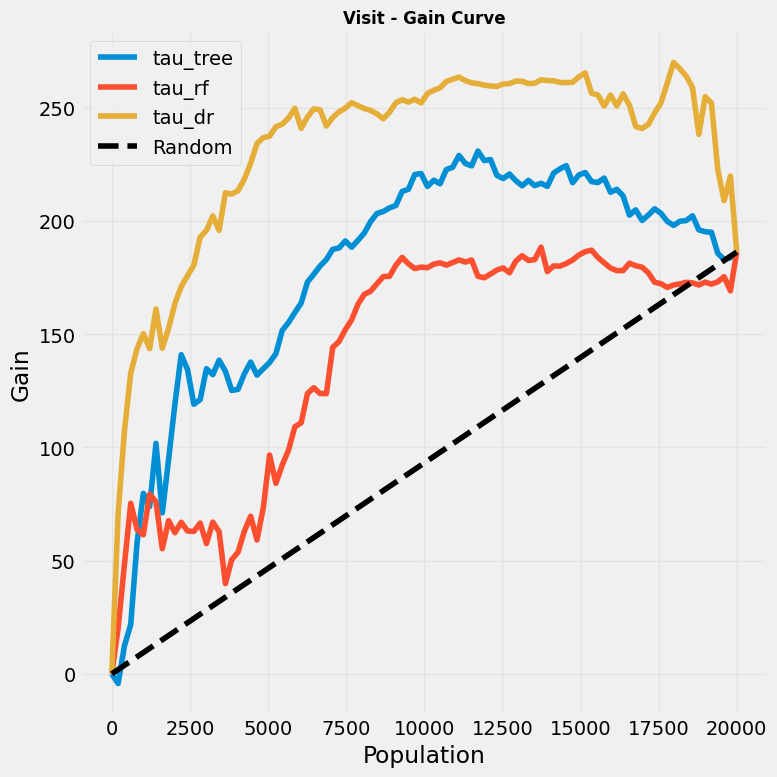

<Figure size 800x500 with 0 Axes>

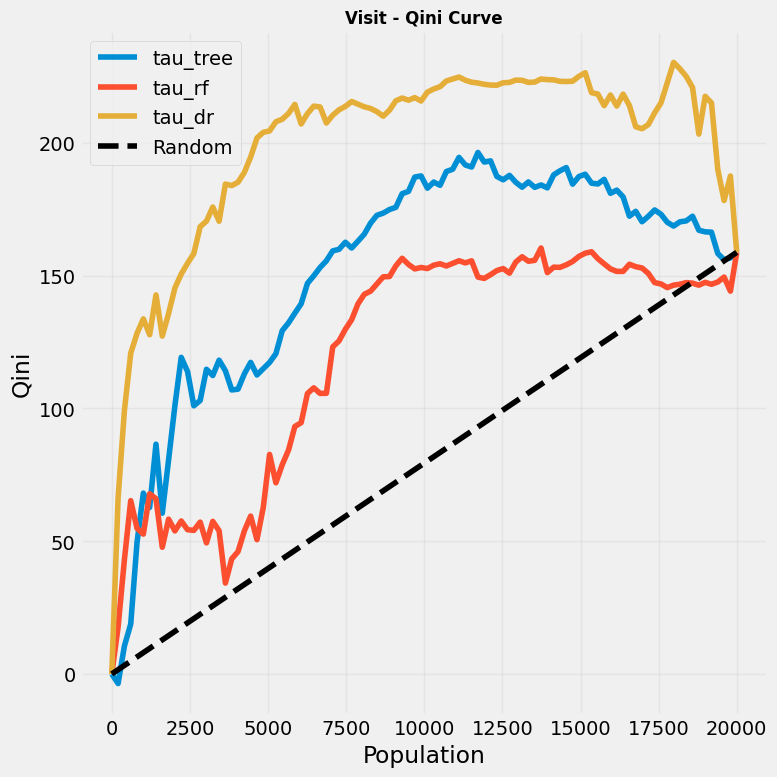

=== Conversion After Visit Uplift 분석 ===


<Figure size 800x500 with 0 Axes>

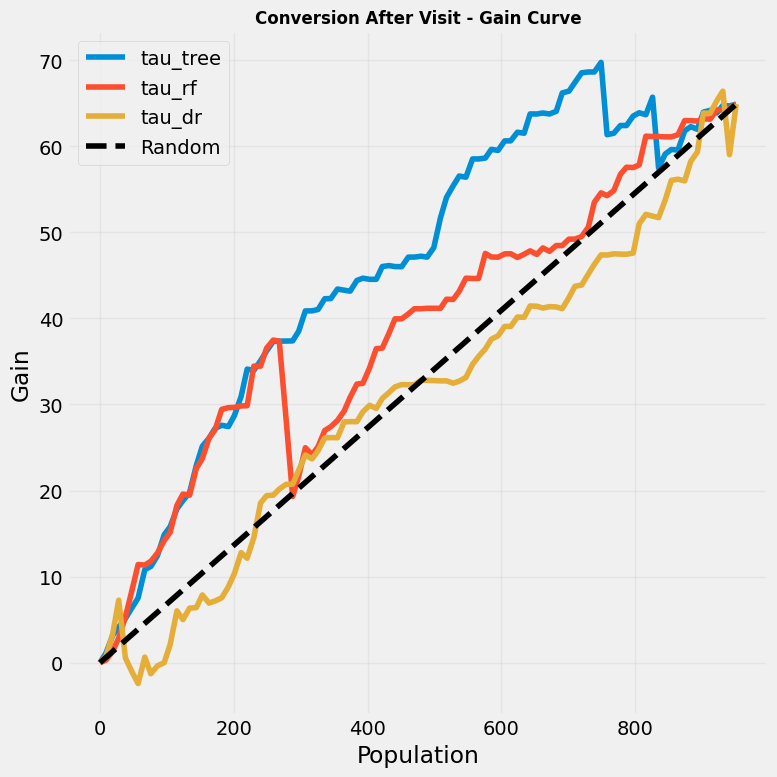

<Figure size 800x500 with 0 Axes>

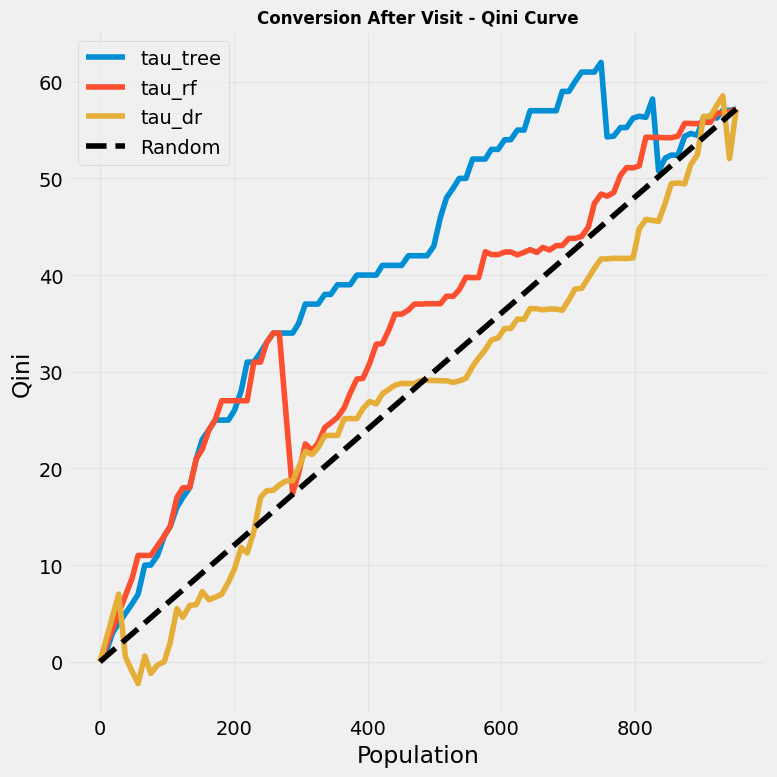

=== AUUC Score 분석 ===
AUUC Scores (Visit):
tau_tree    0.7641
tau_rf      0.6052
tau_dr      1.0000
dtype: float64

AUUC Scores (Conversion After Visit):
tau_tree    0.5630
tau_rf      0.4798
tau_dr      0.3782
dtype: float64


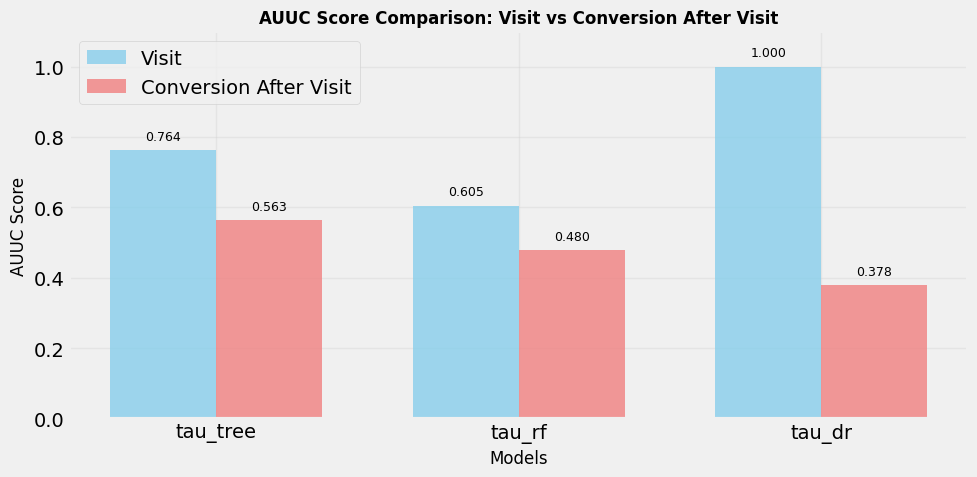

=== 모델 성능 요약 ===

성능 요약 테이블:
      Model  Visit_AUUC  Conversion_AUUC  Difference
0  tau_tree      0.7641           0.5630     -0.2011
1    tau_rf      0.6052           0.4798     -0.1255
2    tau_dr      1.0000           0.3782     -0.6218

최고 성능 모델:
  Visit: tau_dr (AUUC: 1.0000)
  Conversion: tau_tree (AUUC: 0.5630)

* 모든 점수는 0-1 범위로 정규화됨


In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalml.metrics import plot_gain, plot_qini, auuc_score

# =============================================================================
# 데이터 전처리
# =============================================================================
print("=== 데이터 전처리 ===")

# 방문 데이터 1차원 변환
y_test_v_1d = np.array(y_test_v).flatten()
t_test_v_1d = np.array(t_test_v).flatten()
tau_hat_test_v_tree_1d = np.array(tau_hat_test_v_tree).flatten()
tau_hat_test_v_rf_1d = np.array(tau_hat_test_v_rf).flatten()

# 전환 데이터 1차원 변환
y_test_c_1d = np.array(y_test_c).flatten()
t_test_c_1d = np.array(t_test_c).flatten()
tau_hat_test_c_tree_1d = np.array(tau_hat_test_c_tree).flatten()
tau_hat_test_c_rf_1d = np.array(tau_hat_test_c_rf).flatten()

# 방문 데이터프레임 생성
df_visit = pd.DataFrame({
    'conversion': y_test_v_1d,
    'treatment_assign': pd.Series(t_test_v_1d).map({'control': 0, 'treatment': 1}),
    'tau_tree': tau_hat_test_v_tree_1d,
    'tau_rf': tau_hat_test_v_rf_1d,
    'tau_dr': visit_effect_test
})

# 전환 데이터프레임 생성
df_conversion = pd.DataFrame({
    'conversion': y_test_c_1d,
    'treatment_assign': pd.Series(t_test_c_1d).map({'control': 0, 'treatment': 1}),
    'tau_tree': tau_hat_test_c_tree_1d,
    'tau_rf': tau_hat_test_c_rf_1d,
    "tau_dr": conversion_effect_test
})

# =============================================================================
# 1. Visit 그래프들
# =============================================================================
print("=== Visit Uplift 분석 ===")

# Visit - Gain Curve
plt.figure(figsize=(8, 5))
plot_gain(df_visit, outcome_col='conversion', treatment_col='treatment_assign',
          random_seed=42, n=100)
plt.title('Visit - Gain Curve', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visit - Qini Curve
plt.figure(figsize=(8, 5))
plot_qini(df_visit, outcome_col='conversion', treatment_col='treatment_assign',
          random_seed=42, n=100)
plt.title('Visit - Qini Curve', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# 2. Conversion After Visit 그래프들
# =============================================================================
print("=== Conversion After Visit Uplift 분석 ===")

# Conversion - Gain Curve
plt.figure(figsize=(8, 5))
plot_gain(df_conversion, outcome_col='conversion', treatment_col='treatment_assign',
          random_seed=42, n=100)
plt.title('Conversion After Visit - Gain Curve', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Conversion - Qini Curve
plt.figure(figsize=(8, 5))
plot_qini(df_conversion, outcome_col='conversion', treatment_col='treatment_assign',
          random_seed=42, n=100)
plt.title('Conversion After Visit - Qini Curve', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# 3. AUUC Score 계산 및 시각화 (정규화된 점수만)
# =============================================================================
print("=== AUUC Score 분석 ===")

# 원본 AUUC 점수 계산
auuc_visit_raw = auuc_score(df_visit, outcome_col='conversion',
                            treatment_col='treatment_assign', normalize=True)
auuc_conversion_raw = auuc_score(df_conversion, outcome_col='conversion',
                                 treatment_col='treatment_assign', normalize=True)

# 전체 최대값으로 정규화
all_scores = pd.concat([auuc_visit_raw, auuc_conversion_raw])
max_val = all_scores.max()

# 정규화된 점수
auuc_visit = auuc_visit_raw / max_val
auuc_conversion = auuc_conversion_raw / max_val

print("AUUC Scores (Visit):")
print(auuc_visit.round(4))
print("\nAUUC Scores (Conversion After Visit):")
print(auuc_conversion.round(4))

# 모델별 점수 리스트
models = list(auuc_visit.index)
visit_scores = [auuc_visit[model] for model in models]
conversion_scores = [auuc_conversion[model] for model in models]

# AUUC Score 비교 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, visit_scores, width, label='Visit', alpha=0.8, color='skyblue')
bars2 = ax.bar(x + width/2, conversion_scores, width, label='Conversion After Visit', alpha=0.8, color='lightcoral')

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('AUUC Score', fontsize=12)
ax.set_title('AUUC Score Comparison: Visit vs Conversion After Visit', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.1)

# 정규화된 값 표시
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# =============================================================================
# 4. 결과 요약 (정규화된 점수만)
# =============================================================================
print("=== 모델 성능 요약 ===")

summary_df = pd.DataFrame({
    'Model': models,
    'Visit_AUUC': visit_scores,
    'Conversion_AUUC': conversion_scores,
    'Difference': [conversion_scores[i] - visit_scores[i] for i in range(len(models))]
})

print("\n성능 요약 테이블:")
print(summary_df.round(4))
print(f"\n최고 성능 모델:")
print(f"  Visit: {models[np.argmax(visit_scores)]} (AUUC: {max(visit_scores):.4f})")
print(f"  Conversion: {models[np.argmax(conversion_scores)]} (AUUC: {max(conversion_scores):.4f})")

print("\n* 모든 점수는 0-1 범위로 정규화됨")

# Uplift 모델 성능 분석 및 전략적 해석

## 1. AUUC 점수 비교 (Area Under the Uplift Curve)

### Visit Uplift 성능

| 모델                     | AUUC 점수 | 순위 |
|--------------------------|-----------|------|
| DR-Learner (`tau_dr`)    | 1.0000    | 1위  |
| Tree 모델 (`tau_tree`)   | 0.7641    | 2위  |
| Random Forest (`tau_rf`) | 0.6052    | 3위  |

### Conversion After Visit 성능

| 모델                     | AUUC 점수 | 순위 |
|--------------------------|-----------|------|
| Tree 모델 (`tau_tree`)   | 0.5630    | 1위  |
| Random Forest (`tau_rf`) | 0.4798    | 2위  |
| DR-Learner (`tau_dr`)    | 0.3782    | 3위  |

---

## 2. 모델별 성능 특성 분석

### DR-Learner (Doubly Robust)
- Visit에서 매우 뛰어난 성능을 보이며 AUUC 점수 1.0000으로 가장 우수함
- 반면 Conversion에서는 AUUC 점수 0.3782로 하위권
- Visit 대비 Conversion 성능 차이: -0.6218
- **해석**: 방문을 유도하는 데에는 매우 효과적이나, 방문 이후 실제 전환으로의 연결은 제한적임

### Tree 모델
- Visit에서 AUUC 0.7641로 중상위권
- Conversion에서는 AUUC 0.5630으로 가장 뛰어난 성능
- Visit 대비 Conversion 성능 차이: -0.2011
- **해석**: 전환율 제고에 가장 효과적인 모델로, 방문 이후 구매 유도에 강점

### Random Forest
- Visit에서 AUUC 0.6052, Conversion에서는 0.4798으로 중간 수준의 성능
- 성능 차이: -0.1255로 가장 작음
- **해석**: 방문과 전환 모두에서 안정적인 성능을 보이나, 두드러진 장점은 부족

---

## 3. 마케팅 전략에 따른 모델 선택 방안

### 3.1 방문 트래픽 증대가 주목표인 경우
- **DR-Learner 추천**
- Visit Uplift AUUC 점수 1.0000으로 가장 높음
- 브랜드 인지도 제고, 웹사이트 유입 확대 등의 캠페인에 적합

### 3.2 실제 전환(매출) 극대화가 주목표인 경우
- **Tree 모델 추천**
- Conversion Uplift AUUC 점수 0.5630으로 가장 뛰어남
- 구매 전환 중심의 퍼포먼스 마케팅에 효과적

### 3.3 균형잡힌 성과를 원하는 경우
- **Tree 모델 또는 Random Forest 고려 가능**
- Tree 모델은 전환 성능 중심이지만 방문 uplift도 우수
- Random Forest는 두 지표에서 모두 안정적인 평균 수준 이상의 성과

---

## 4. 예산 배분 및 운영 전략

### 단계적 접근 전략
1. **1단계**: DR-Learner를 통해 방문자 수 확보
2. **2단계**: Tree 모델을 활용하여 전환률 극대화
3. 상황에 따라 두 모델을 적절히 전환·조합하여 유연하게 운영

---

## 5. 성능 차이 분석 및 전략적 고려사항

- DR-Learner의 Visit 성능은 Tree 모델 대비 약 **31% 우수** (1.0000 vs 0.7641)
- 반대로 Tree 모델의 Conversion 성능은 DR-Learner 대비 약 **49% 우수** (0.5630 vs 0.3782)

이러한 성능 차이는 마케팅 전략 수립 및 예산 배분 시 중요한 근거가 되며, 목적에 따라 모델을 구분 적용하거나 통합 전략을 활용하는 것이 바람직하다.

**참고**: 모든 AUUC 점수는 0-1 범위로 정규화되었으며, 상대적 성능 비교는 여전히 유효함.